# Backorder Prediction

# 1. Business Problem

## 1.1. Description

- **Source**: https://www.kaggle.com/ Currently the page is not available

- **Data Source**: https://github.com/rodrigosantis1/backorder_prediction/blob/master/dataset.rar

- **Problem Statement**:
Determining beforehand, whether or not a product will go to backorder based on the provided historical data.

## 1.2. Source/Useful Links

Some articles and reference blogs about the problem statement

1. https://www.researchgate.net/publication/319553365_Predicting_Material_Backorders_in_Inventory_Management_using_Machine_Learning

2. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00345-2
3. https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
4. https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/

## 1.3. Real-world/Business objectives and constraints.

* No low-latency requirement.
* Interpretability is important.

# 2. Machine Learning Problem Formulation

## 2.1. Data

### 2.1.1. Data Overview

- Source: https://github.com/rodrigosantis1/backorder_prediction/blob/master/dataset.rar
- We have two data files: one for training and another for testing.

## 2.2. Mapping the real-world problem to an ML problem

### 2.2.1. Type of Machine Learning Problem

**Binary Classification Problem**: Since the target variable has two classes - 'Yes' and 'No' which corresponds to whether the product went ot backorder or not.

### 2.2.2. Performance Metric

Since this is an imbalance classification problem having positive class points very less we have to choose performance metrics accordingly. For this case False Negative is a bigger concern than False Positive. Hence for this Recall is more Important for us than Precision. This is because it is okay to predict a product will go to backorder than it is actually to backorder as it can be dealt with easily. But if fail to predict product going to backorder, when it actually went to backorder, it will very negatively impact the company's sales and its reputation along with an additional pressure on the whole supply chain.

* **Area under Precision - Recall curve** : Here we calculate area under the plot of Precision vs Recall. We use this score instead of roc_auc_score. Because this will allow the people on the business side to decide the tradeoff between Precision and Recall. Also Precision-Curve focuses mainly on minority class.

* **F2-Score** : F2 score is used for the case of imbalanced data classification where we want to focus more on the minority class or in other words we want to emphasize more on the Recall.

* **Recall Score** : Recall is the ability of the model to correctly indentify the positive class in the dataset. It is given as (TP/(TP+FN)).

### 2.2.3. Machine Learing Objectives and Constraints

**Objective**: Predict whether a product would go to Backorder or not

**Constraints**:

*   Interpretability
*   No Latency constraints



## 2.3. Train, CV and Test Datasets

Split the dataset randomly into three parts train, cross validation and test with 60%,20%, 20% of data respectively

# 3. Exploratory Data Analysis

## 3.1. Libraries

In [ ]:
!pip install pca

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=3e23aeb01ac2eea2efba338f13000222fa24f3780545e04c38648f2f7b0d5cc9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy
import scipy.stats as st
from scipy.stats import chisquare
import statistics
from sklearn import ensemble, tree, linear_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_roc_curve, RocCurveDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pca import pca
import random
import pickle
from tqdm import tqdm
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

In [ ]:
!pip install rarfile

## 3.2. Data

Data Source:
Dataset was part of the competition 'Can you predict product backorders' which has been discontinued on the kaggle platform and hence the original links are not active.
The dataset was taken from the github link:
https://github.com/rodrigosantis1/backorder_prediction/blob/master/dataset.rar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import rarfile
rar_ref = rarfile.RarFile("/content/drive/MyDrive/dataset.rar", 'r')
rar_ref.extractall('/content')
rar_ref.close()

It was mentioned in the discussion forum that the 'perf_6_month_avg' and 'perf_12_month_avg' have values -99 which indicates missing values.

In [ ]:
# Dictionary containing values for representing NaNs
na_values = {'perf_6_month_avg':-99, 'perf_12_month_avg':-99}

In [ ]:
train = pd.read_csv('../input/cs-backorder/Kaggle_Training_Dataset_v2.csv', na_values=na_values)
test = pd.read_csv('../input/cs-backorder/Kaggle_Test_Dataset_v2.csv', na_values=na_values)

## 3.3. Utility Functions

In [ ]:
# function that returns a new dataframe given percentile values and the corresponding feature
def feature_percentile_dataframe(num1,num2,feature,data):
  df = data.copy()
  l_perc = np.percentile(df[feature], num1)
  h_perc = np.percentile(df[feature], num2)
  return df[(df[feature] > l_perc)  & (df[feature] < h_perc)]

# code taken from https://stackoverflow.com/a/62076347
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

# code taken from https://stackoverflow.com/a/62076347
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

## 3.4. High Level Statistics

### 3.4.1. Basic Statistics of Dataset

In [ ]:
print('Shape of the Dataset : ', train.shape)
print('Number of Rows : ', train.shape[0])
print('Number of Features : ', train.shape[1])

Shape of the Dataset :  (1687861, 23)
Number of Rows :  1687861
Number of Features :  23


### 3.4.2. Columns/Features in the Dataset

In [ ]:
cols = train.columns
print('The Features of the dataset are:')
for i, col in enumerate(cols):
  print(str(i+1)+'. '+str(col))

The Features of the dataset are:
1. sku
2. national_inv
3. lead_time
4. in_transit_qty
5. forecast_3_month
6. forecast_6_month
7. forecast_9_month
8. sales_1_month
9. sales_3_month
10. sales_6_month
11. sales_9_month
12. min_bank
13. potential_issue
14. pieces_past_due
15. perf_6_month_avg
16. perf_12_month_avg
17. local_bo_qty
18. deck_risk
19. oe_constraint
20. ppap_risk
21. stop_auto_buy
22. rev_stop
23. went_on_backorder


### 3.4.3. Top 5 Rows of the Dataset

In [ ]:
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,Yes,No,No,Yes,No,No


### 3.4.4. Bottom 5 Rows of the Dataset

In [ ]:
train.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,NaN,NaN,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,...,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- It appears that the bottom row of the dataset is an invalid entry having all the values as NaN. Hence it would be wise to remove the last row.

In [ ]:
# Removing the last row from the dataset
train.drop(train.tail(1).index,inplace=True)

### 3.4.5. Information about the type of feature and non-null count

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687860 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1558382 non-null  float64
 15  perf_12_month_avg  1565810 non-n

### 3.4.6. Statistics about the numerical features in the dataset

In [ ]:
train.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.558382e+06,1.565810e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,7.823812e-01,7.769763e-01,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.370141e-01,2.304902e-01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-01,6.900000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.500000e-01,8.300000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


### 3.4.7. Missing Values

In [ ]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data.index.name = 'Features'
missing_data

,Total Missing Count,% of Total Observations
Features,,
perf_6_month_avg,129478,0.076711
perf_12_month_avg,122050,0.072310
lead_time,100893,0.059776
sku,0,0.000000
potential_issue,0,0.000000
rev_stop,0,0.000000
stop_auto_buy,0,0.000000
ppap_risk,0,0.000000
oe_constraint,0,0.000000


- lead_time, perf_6_month_avg and perf_12_month_avg are the features having missing values.

### 3.4.8. Data Imabalance

We check data imbalance by seeing the distribution of each class in the target varible.

In [ ]:
train['went_on_backorder'].value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

- It can be seen that the majority class 'No' have more counts than the minority class 'Yes', which  makes this an Imbalanced Dataset.

- Also Since the target variable has only two unique classes, this makes this problem as Binary Classification problem.

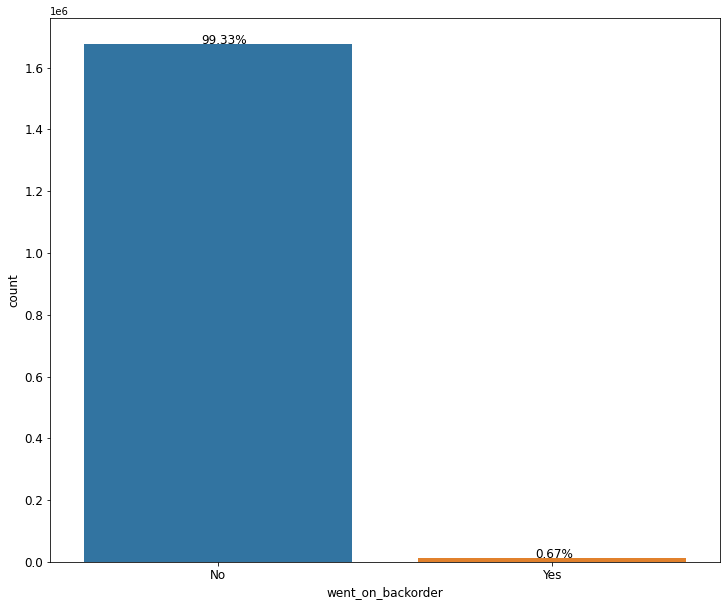

In [ ]:
feature = "went_on_backorder"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- We can verify the data imbalance through above plot.
- It also tells us the proportion of imbalance.
- 99.33% points are negative points.
- 0.67% of points are only positive points.

## 3.5. Feature-wise Analysis

### 3.5.1. Numeric Features

In [ ]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_columns = numeric_features.columns
if len(numeric_columns) != 0:
  print('There are {} numeric features in the dataset:'.format(len(numeric_columns)))
  for i, col in enumerate(numeric_columns):
    print(str(i+1)+'. '+str(col))
else:
  print('There are no numeric features in the dataset')

There are 15 numeric features in the dataset:
1. national_inv
2. lead_time
3. in_transit_qty
4. forecast_3_month
5. forecast_6_month
6. forecast_9_month
7. sales_1_month
8. sales_3_month
9. sales_6_month
10. sales_9_month
11. min_bank
12. pieces_past_due
13. perf_6_month_avg
14. perf_12_month_avg
15. local_bo_qty


- There are total 15 numeric features.

In [ ]:
discrete_feature=[feature for feature in numeric_features if len(train[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


- There are 0 discrete features in the dataset.
- All the numeric features are continuous in nature.

In [ ]:
sns.set_theme()
sns.set_style("darkgrid")

#### 3.5.1.1. Numeric Feature: national_inv

##### PDF of 'national_inv'

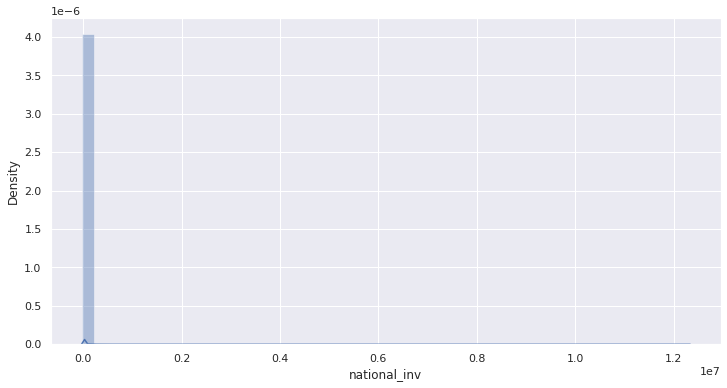

In [ ]:
x = train['national_inv']
plt.figure(figsize=(12,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'national_inv' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'national_inv'

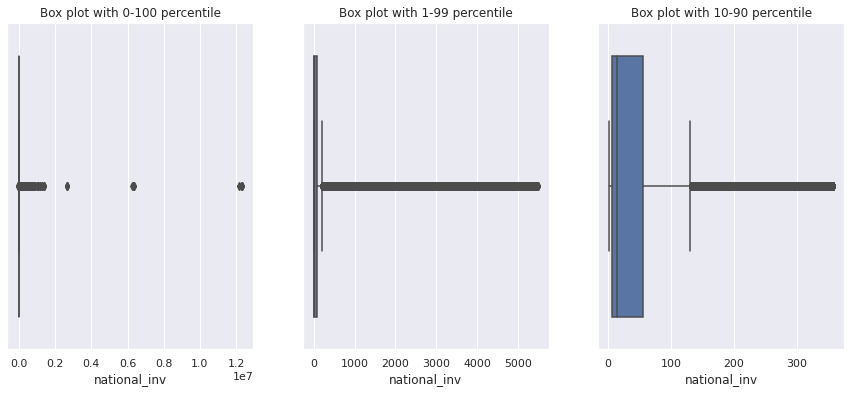

In [ ]:
feature = 'national_inv'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'national_inv' is small as compared to the range of its values.
- There seems to be outliers.
- From the discussion forum, it is being told that there are negative values in the feature, which are valid values, indicating that the shops ordered more than available.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'national_inv'

In [ ]:
feature = 'national_inv'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of national_inv : 496.1117817828493
Median of national_inv : 15.0
Mode of national_inv : 0.0
Skewness of the 'national_inv' feature : 340.2858003326191
Kurtosis of the 'national_inv' feature : 131276.59257932162


- Mode < Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.2. Numeric Feature: lead_time

##### PDF of 'lead_time'

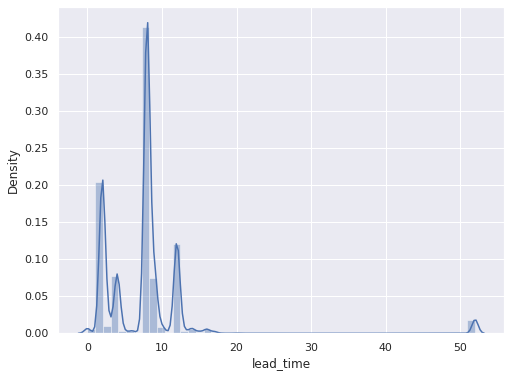

In [ ]:
x = train['lead_time']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'lead_time' is highly right skewed but also have a lot of peaks.

##### Boxplots of 'lead_time'

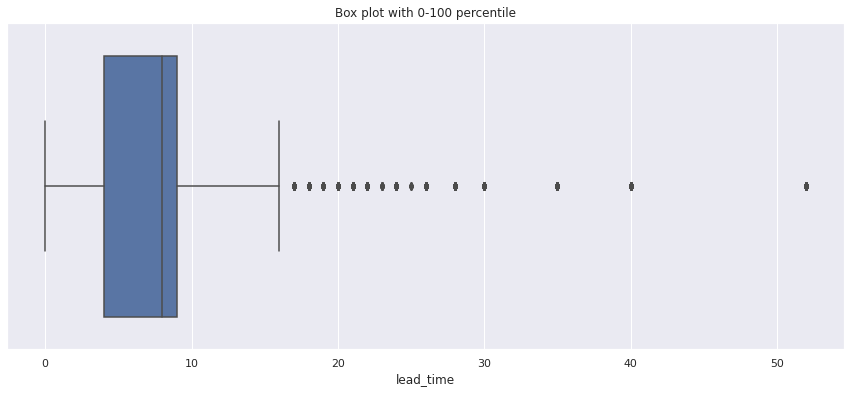

In [ ]:
feature = 'lead_time'
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- IQR of the 'lead_time' is medium as compared to the range of its values.
- There seems to be outliers.
- From our previous analysis we know that there are a lot of missing values.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'lead_time'

In [ ]:
feature = 'lead_time'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of lead_time : 7.872267035168343
Median of lead_time : nan
Mode of lead_time : 8.0
Skewness of the 'lead_time' feature : 4.556295427885091
Kurtosis of the 'lead_time' feature : 26.23722750420738


- Feature a little bit right skewd as it has low positive skewdness value.
- Kurtosis value is also low impling that there are a some values located in the tail part of the distribution.

#### 3.5.1.3. Numeric Feature: in_transit_qty

##### PDF of 'in_transit_qty'

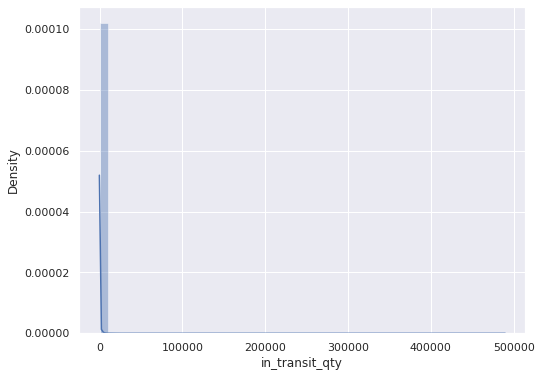

In [ ]:
x = train['in_transit_qty']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'in_transit_qty' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'in_transit_qty'

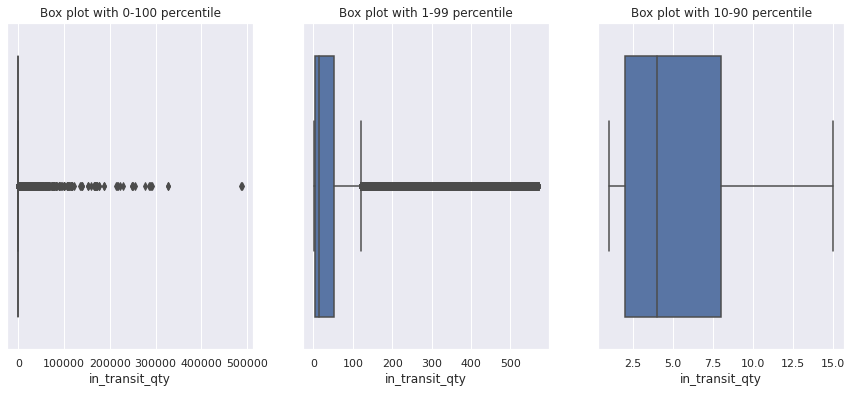

In [ ]:
feature = 'in_transit_qty'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'in_transit_qty' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'in_transit_qty'

In [ ]:
feature = 'in_transit_qty'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of in_transit_qty : 44.05202208713993
Median of in_transit_qty : 0.0
Mode of in_transit_qty : 0.0
Skewness of the 'in_transit_qty' feature : 166.18340424761558
Kurtosis of the 'in_transit_qty' feature : 39606.10405290813


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.4. Numeric Feature: forecast_3_month

##### PDF of 'forecast_3_month'

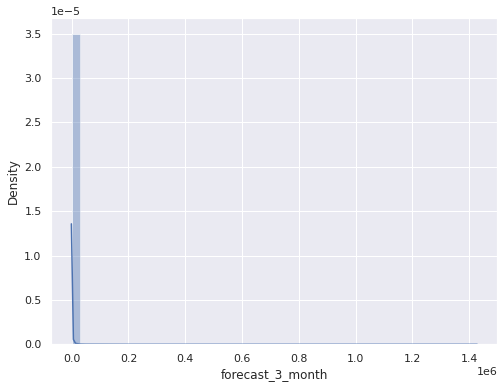

In [ ]:
x = train['forecast_3_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'forecast_3_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'forecast_3_month'

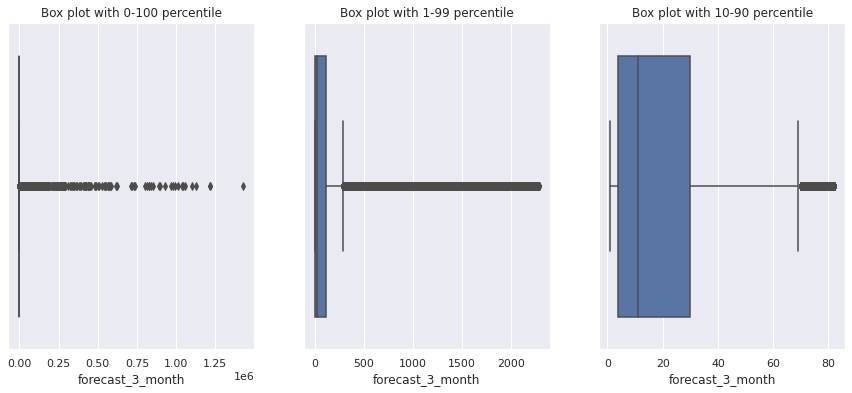

In [ ]:
feature = 'forecast_3_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'forecast_3_month' is small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'forecast_3_month'

In [ ]:
feature = 'forecast_3_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of forecast_3_month : 178.1192835898712
Median of forecast_3_month : 0.0
Mode of forecast_3_month : 0.0
Skewness of the 'forecast_3_month' feature : 138.96832519579834
Kurtosis of the 'forecast_3_month' feature : 25637.55029993227


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.5. Numeric Feature: forecast_6_month

##### PDF of 'forecast_6_month'

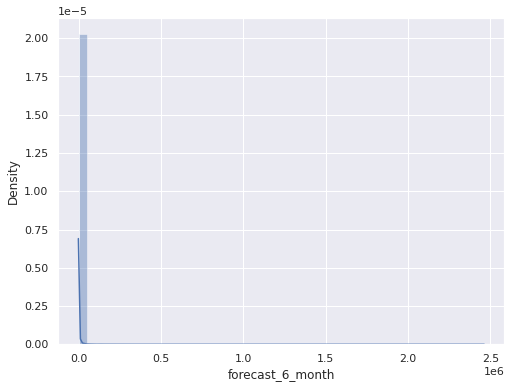

In [ ]:
x = train['forecast_6_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'forecast_6_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'forecast_6_month'

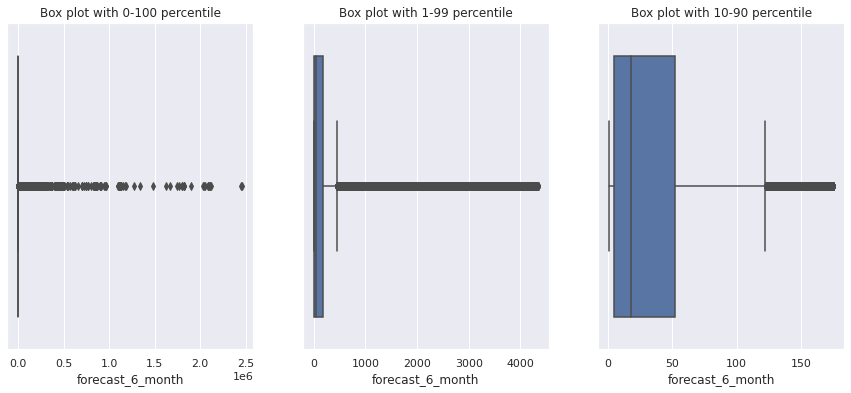

In [ ]:
feature = 'forecast_6_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'forecast_6_month' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'forecast_6_month'

In [ ]:
feature = 'forecast_6_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of forecast_6_month : 344.98666358584245
Median of forecast_6_month : 0.0
Mode of forecast_6_month : 0.0
Skewness of the 'forecast_6_month' feature : 138.96142721254265
Kurtosis of the 'forecast_6_month' feature : 25189.903788272073


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.6. Numeric Feature: forecast_9_month

##### PDF of 'forecast_9_month'

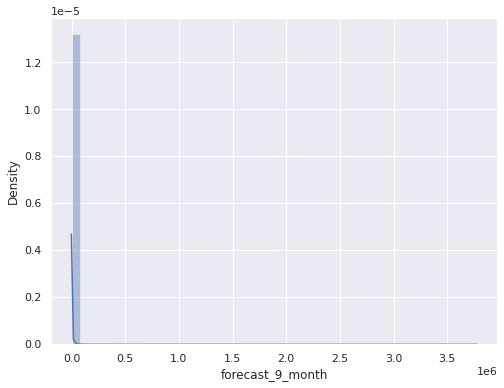

In [ ]:
x = train['forecast_9_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'forecast_9_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'forecast_9_month'

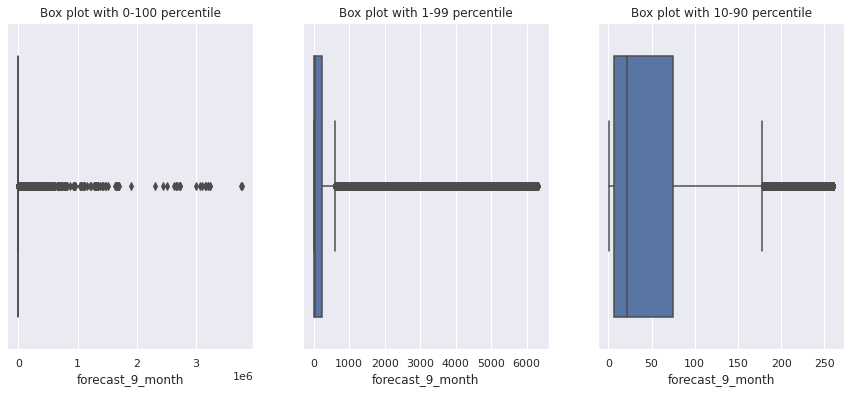

In [ ]:
feature = 'forecast_9_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'forecast_9_month' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'forecast_9_month'

In [ ]:
feature = 'forecast_9_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of forecast_9_month : 506.3644306992286
Median of forecast_9_month : 0.0
Mode of forecast_9_month : 0.0
Skewness of the 'forecast_9_month' feature : 143.298874740098
Kurtosis of the 'forecast_9_month' feature : 27048.452312581445


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.7. Numeric Feature: sales_1_month

##### PDF of 'sales_1_month'

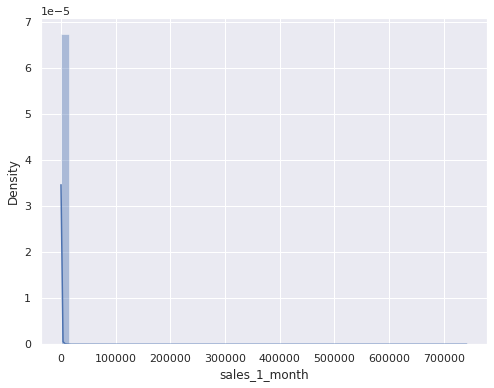

In [ ]:
x = train['sales_1_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'sales_1_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'sales_1_month'

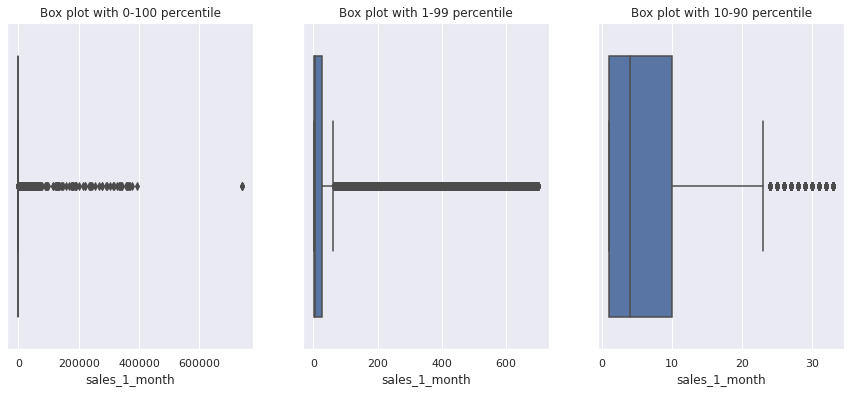

In [ ]:
feature = 'sales_1_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'sales_1_month' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'sales_1_month'

In [ ]:
feature = 'sales_1_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of sales_1_month : 55.926068512791346
Median of sales_1_month : 0.0
Mode of sales_1_month : 0.0
Skewness of the 'sales_1_month' feature : 196.1199898556541
Kurtosis of the 'sales_1_month' feature : 53855.92556025887


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.8. Numeric Feature: sales_3_month

##### PDF of 'sales_3_month'

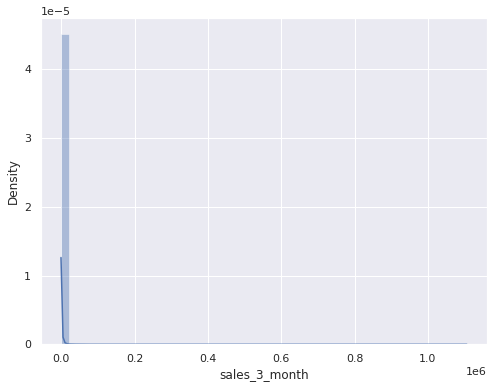

In [ ]:
x = train['sales_3_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'sales_3_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'sales_3_month'

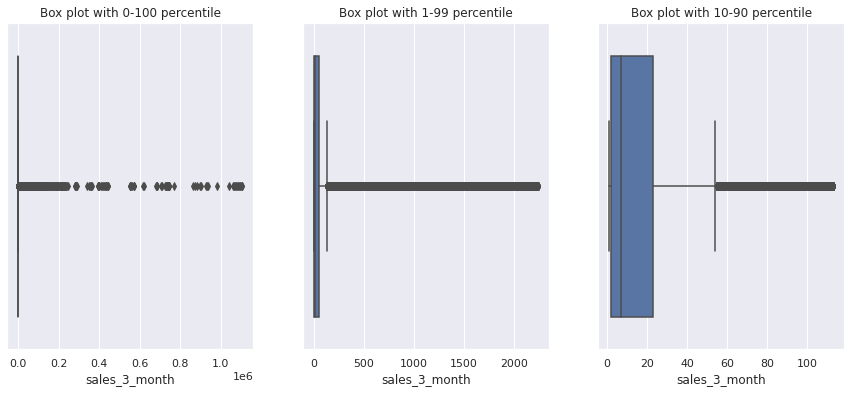

In [ ]:
feature = 'sales_3_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'sales_3_month' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'sales_3_month'

In [ ]:
feature = 'sales_3_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of sales_3_month : 175.0259304681668
Median of sales_3_month : 1.0
Mode of sales_3_month : 0.0
Skewness of the 'sales_3_month' feature : 141.2863795444832
Kurtosis of the 'sales_3_month' feature : 24198.860650933373


- Mode < Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.9. Numeric Feature: sales_6_month

##### PDF of 'sales_6_month'

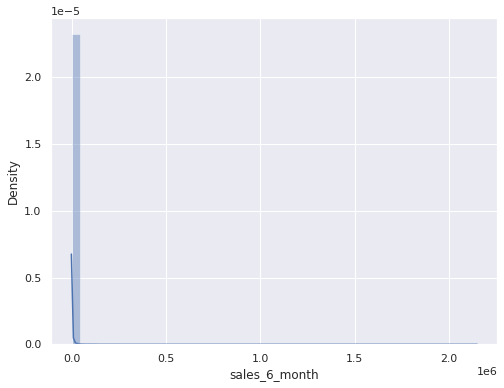

In [ ]:
x = train['sales_6_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'sales_6_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'sales_6_month'

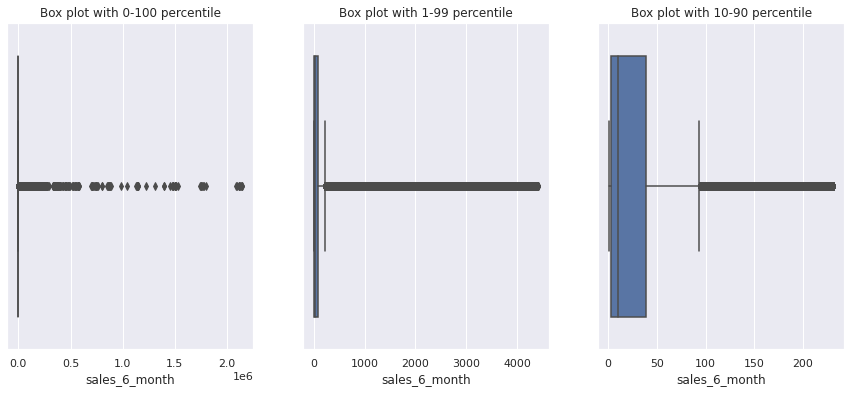

In [ ]:
feature = 'sales_6_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'sales_6_month' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'sales_6_month'

In [ ]:
feature = 'sales_6_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of sales_6_month : 341.7288394772078
Median of sales_6_month : 2.0
Mode of sales_6_month : 0.0
Skewness of the 'sales_6_month' feature : 139.17671201086372
Kurtosis of the 'sales_6_month' feature : 24305.44501338931


- Mode < Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.10. Numeric Feature: sales_9_month

##### PDF of 'forecast_9_month'

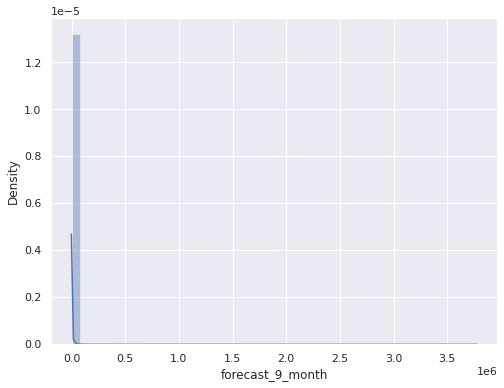

In [ ]:
x = train['forecast_9_month']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'sales_9_month' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'forecast_9_month'

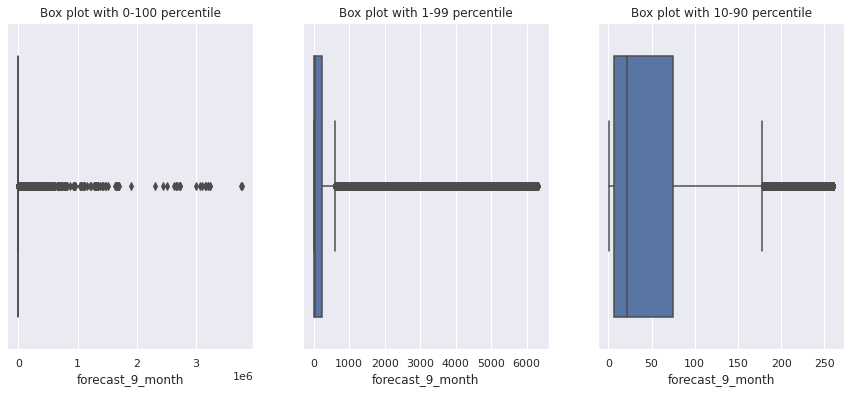

In [ ]:
feature = 'forecast_9_month'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'sales_9_month' is small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'forecast_9_month'

In [ ]:
feature = 'forecast_9_month'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of forecast_9_month : 506.3644306992286
Median of forecast_9_month : 0.0
Mode of forecast_9_month : 0.0
Skewness of the 'forecast_9_month' feature : 143.298874740098
Kurtosis of the 'forecast_9_month' feature : 27048.452312581445


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.11. Numeric Feature: min_bank

##### PDF of 'min_bank'

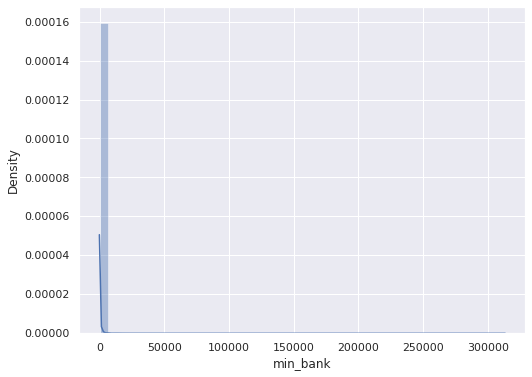

In [ ]:
x = train['min_bank']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'min_bank' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'min_bank'

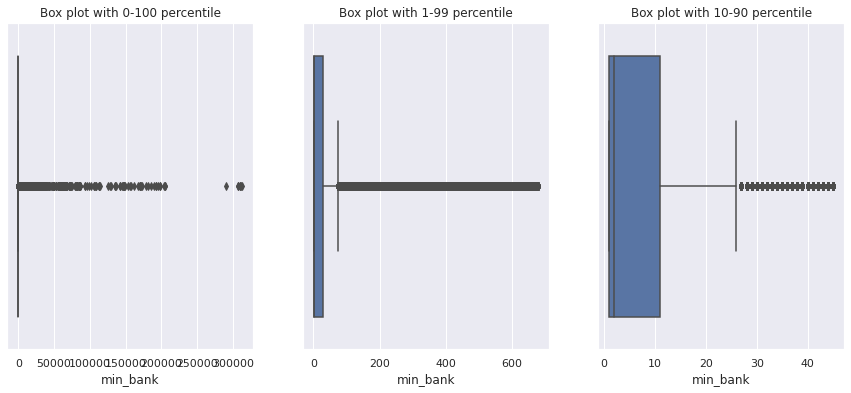

In [ ]:
feature = 'min_bank'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x= x2, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR of the 'min_bank' is very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'min_bank'

In [ ]:
feature = 'min_bank'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of min_bank : 52.772303390091594
Median of min_bank : 0.0
Mode of min_bank : 0.0
Skewness of the 'min_bank' feature : 131.21264893012795
Kurtosis of the 'min_bank' feature : 23549.240091008585


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.12. Numeric Feature: pieces_past_due

##### PDF of 'pieces_past_due'

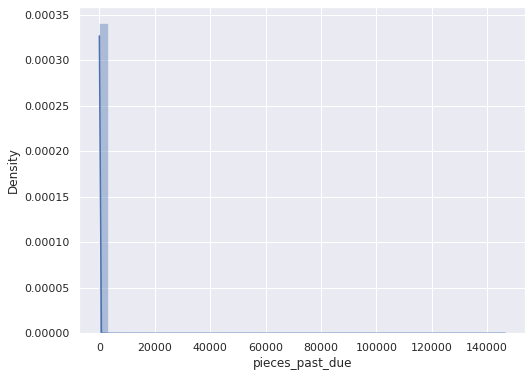

In [ ]:
x = train['pieces_past_due']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'pieces_past_due' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'pieces_past_due'

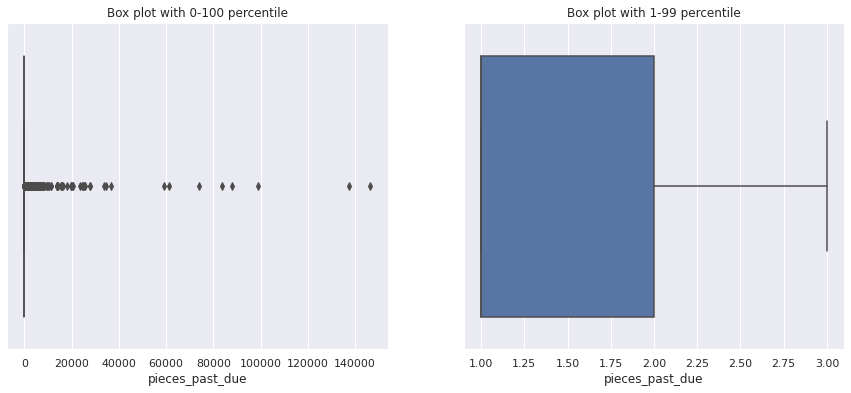

In [ ]:
feature = 'pieces_past_due'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 2, figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x= x1, data=df1,  orient='v' , ax=axes[1])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')

- IQR of the 'pieces_past_due' is very very small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'pieces_past_due'

In [ ]:
feature = 'pieces_past_due'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of pieces_past_due : 2.0437240055454837
Median of pieces_past_due : 0.0
Mode of pieces_past_due : 0.0
Skewness of the 'pieces_past_due' feature : 412.39190039252696
Kurtosis of the 'pieces_past_due' feature : 207663.2258415861


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1..13. Numeric Feature: perf_6_month_avg

##### PDF of 'perf_6_month_avg'

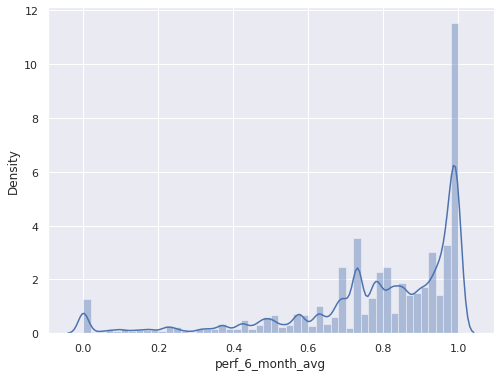

In [ ]:
x = train['perf_6_month_avg']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'perf_6_month_avg' is highly left skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.
- The box plots appear to be like this due to left skewdness.

##### Boxplots of 'perf_6_month_avg'

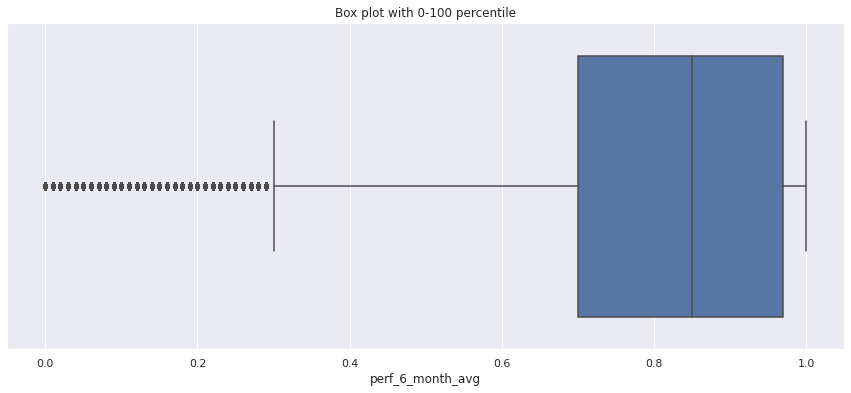

In [ ]:
feature = 'perf_6_month_avg'
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- IQR of the 'perf_6_month_avg' is large as compared to the range of its values.
- There seems to be outliers.

##### Some statistics of 'perf_6_month_avg'

In [ ]:
feature = 'perf_6_month_avg'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of perf_6_month_avg : 0.7823811940800672
Median of perf_6_month_avg : nan
Mode of perf_6_month_avg : 0.99
Skewness of the 'perf_6_month_avg' feature : -1.5849790517782292
Kurtosis of the 'perf_6_month_avg' feature : 2.275871675113145


- Feature left skewd as it has low negative skewdness value.
- Kurtosis value is low impling that there are a some values located in the tail part of the distribution.

#### 3.5.1.14. Numeric Feature: perf_12_month_avg

##### PDF of 'perf_12_month_avg'

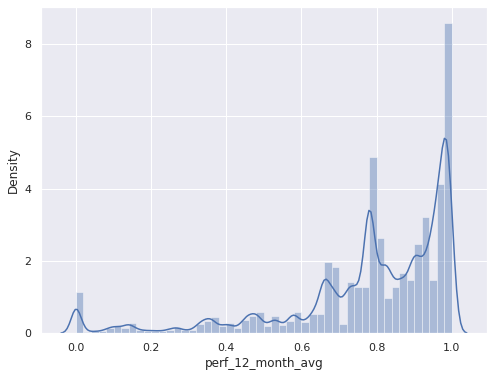

In [ ]:
x = train['perf_12_month_avg']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'perf_12_month_avg' is highly left skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'perf_12_month_avg'

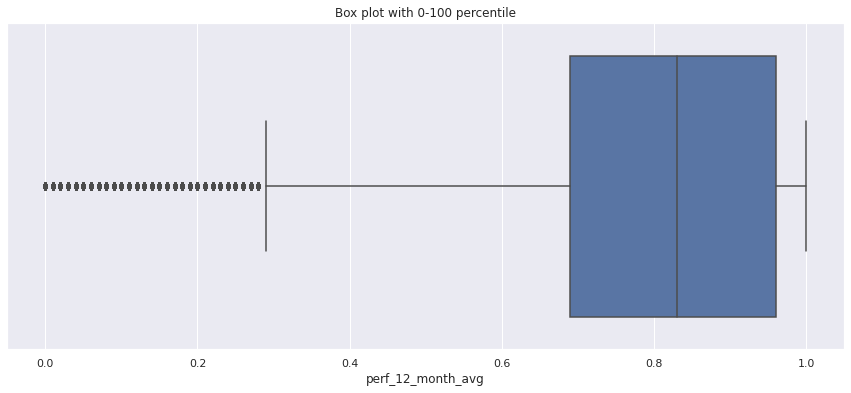

In [ ]:
feature = 'perf_12_month_avg'
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- IQR of the 'perf_12_month_avg' is large as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to left skewdness.

##### Some statistics of 'perf_12_month_avg'

In [ ]:
feature = 'perf_12_month_avg'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of perf_12_month_avg : 0.7769762678715476
Median of perf_12_month_avg : nan
Mode of perf_12_month_avg : 0.99
Skewness of the 'perf_12_month_avg' feature : -1.6177075400141825
Kurtosis of the 'perf_12_month_avg' feature : 2.416416262597326


- Feature left skewd as it has low negative skewdness value.
- Kurtosis value is low impling that there are a some values located in the tail part of the distribution.

#### 3.5.1.15. Numeric Feature: local_bo_qty

##### PDF of 'local_bo_qty'

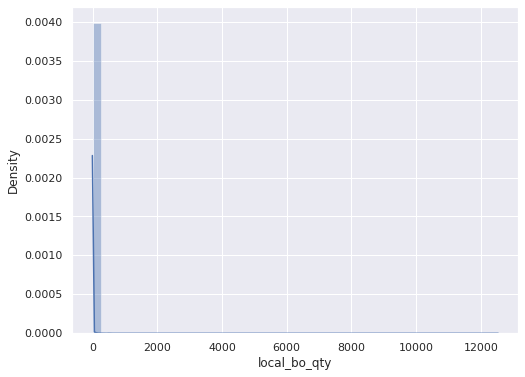

In [ ]:
x = train['local_bo_qty']
plt.figure(figsize=(8,6))
ax = sns.distplot(x, hist=True)

- The pdf of the feature 'local_bo_qty' is highly right skewed which can be seen through the plot.
- This can be due to outliers and need further investigation.

##### Boxplots of 'local_bo_qty'

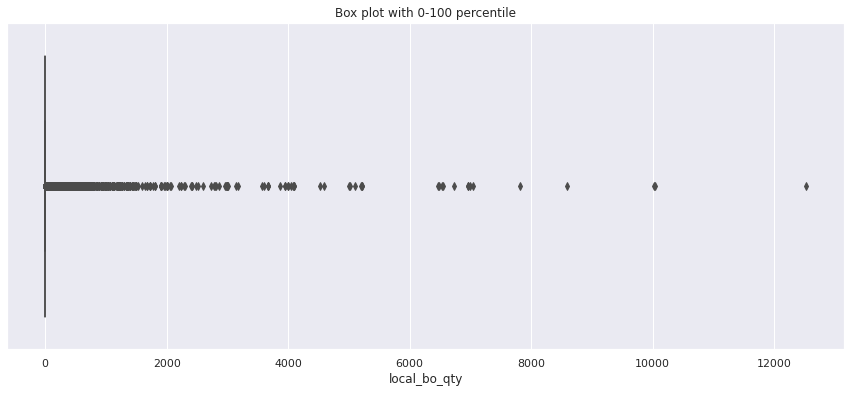

In [ ]:
feature = 'local_bo_qty'
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x= x, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- IQR of the 'local_bo_qty' is small as compared to the range of its values.
- There seems to be outliers.
- The box plots appear to be like this due to right skewdness and a lot of values being present on the tail part of the distribution.

##### Some statistics of 'local_bo_qty'

In [ ]:
feature = 'local_bo_qty'
print('Mean of {} : {}'.format(feature, np.mean(train[feature])))
print('Median of {} : {}'.format(feature, np.median(train[feature])))
print('Mode of {} : {}'.format(feature, statistics.mode(train[feature])))
print("Skewness of the '{}' feature : {}".format(feature, train[feature].skew()))
print("Kurtosis of the '{}' feature : {}".format(feature, train[feature].kurt()))

Mean of local_bo_qty : 0.6264506534902183
Median of local_bo_qty : 0.0
Mode of local_bo_qty : 0.0
Skewness of the 'local_bo_qty' feature : 165.19054793748316
Kurtosis of the 'local_bo_qty' feature : 38154.955457397235


- Mode <= Median < Mean, this implies there is right skewdness.
- Feature heavily right skewd as it has high positive skewdness value.
- Kurtosis value is very high impling that there are a lot of values located in the tail part of the distribution.

#### 3.5.1.16. Correlation between Numeric Features

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

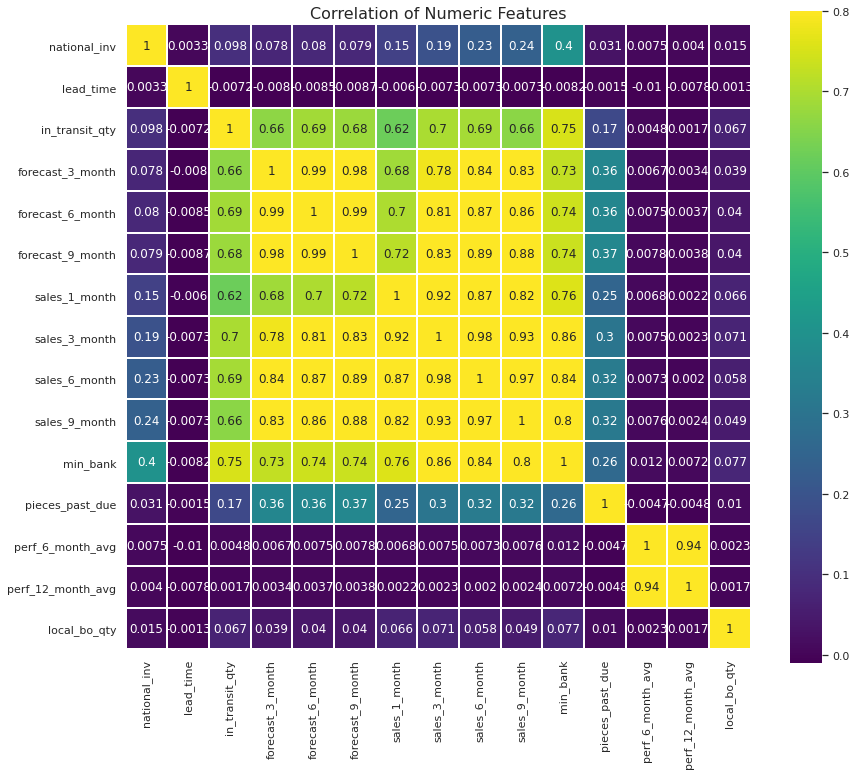

In [ ]:
correlation = numeric_features.corr()
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8,annot=True,cmap='viridis',linecolor="white",linewidths=0.01)

Above correlation analysis reveals that:
- Forecast columns are very much correlated with each other.
- Sales columns are also very much correlated with each other.
- Forecast and sales columns are also very much correlated with each other. These correlations seems logical as forecast depends on sales and previous forecasts
- Performance columns are also very much correlated with each other.
- 'pieces_past_due' also shows some correlation with forecast, sales and 'min_bank' columns.
- 'min_bank' column showing alot of correlation with forecast, sales and 'in_transit_qty' columns.
- 'in_transit_qty' is also correlated to forecast and sales columns.
- 'national_inv' is showing some correlation with 'min_bank' column. 

### 3.5.2. Categorical Features

In [ ]:
categorical_features = train.select_dtypes(include=[np.object])
categorical_columns = categorical_features.columns
if len(categorical_columns) != 0:
  print('There are {} categorical features in the dataset'.format(len(categorical_columns)))
  for i, col in enumerate(categorical_columns):
    print(str(i+1)+'. '+str(col))
else:
  print('There are no categorical features in the dataset')

There are 8 categorical features in the dataset
1. sku
2. potential_issue
3. deck_risk
4. oe_constraint
5. ppap_risk
6. stop_auto_buy
7. rev_stop
8. went_on_backorder


- There are 7 categorical features
- 8th feature is the target variable.

In [ ]:
for col in categorical_columns:
  print('Number of unique categories in {} feature : {}'. format(col, train[col].nunique()))

Number of unique categories in sku feature : 1687860
Number of unique categories in potential_issue feature : 2
Number of unique categories in deck_risk feature : 2
Number of unique categories in oe_constraint feature : 2
Number of unique categories in ppap_risk feature : 2
Number of unique categories in stop_auto_buy feature : 2
Number of unique categories in rev_stop feature : 2
Number of unique categories in went_on_backorder feature : 2


- Out of 8 categorical features only one feature have a lot of unique values 'sku' which appears to be equal to length of the dataset.
- It implies that 'sku' which is the unique product id is acting same as the index hence there is no utility of this feature.

#### 3.5.2.1. Categorical Featuere: sku

In [ ]:
# Removing the 'sku' column from the dataset
train.drop(['sku'], axis = 1,inplace=True)

In [ ]:
# Shape of the dataset after removing the 'sku' column
print("Shape of the Dataset after removal of 'sku' column: ", train.shape)

Shape of the Dataset after removal of 'sku' column:  (1687860, 22)


#### 3.5.2.2. Categorical Featuere: potential_issue

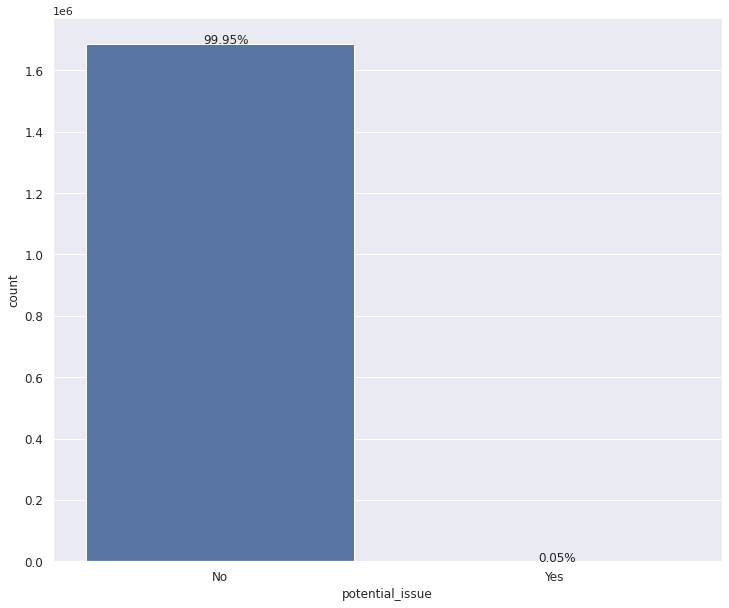

In [ ]:
feature = "potential_issue"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- 99.95% of data points have 'potential_issue' flag as 'No'.
- 0.05% of data points have 'potential_issue' flag as 'Yes'.
- There is imbalance in the distribution of points for the two values of 'potential_issue'.

In [ ]:
train["potential_issue"].value_counts()

No     1686953
Yes        907
Name: potential_issue, dtype: int64

#### 3.5.2.3. Categorical Featuere: deck_risk

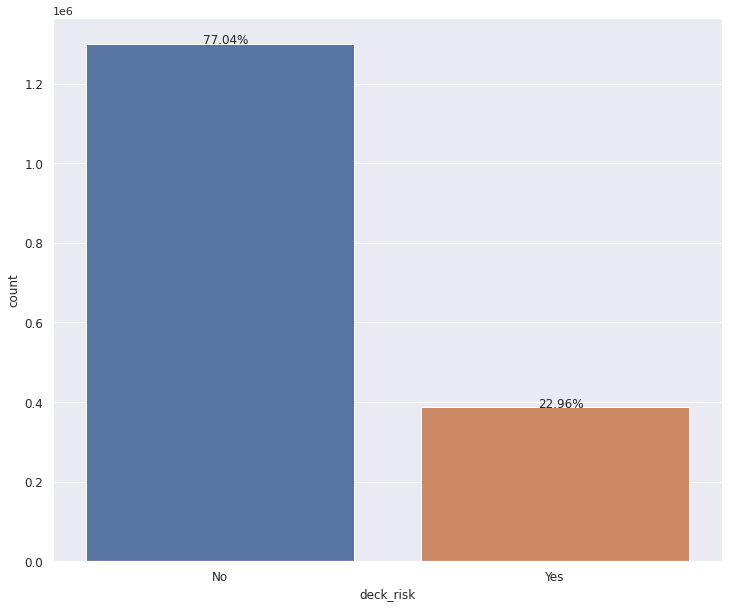

In [ ]:
feature = "deck_risk"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- 77.04% of data points have 'deck_risk' flag as 'No'.
- 22.96% of data points have 'deck_risk' flag as 'Yes'.
- There is imbalance in the distribution of points for the two values of 'deck_risk'.

In [ ]:
train["deck_risk"].value_counts()

No     1300377
Yes     387483
Name: deck_risk, dtype: int64

#### 3.5.2.4. Categorical Featuere: oe_constraint

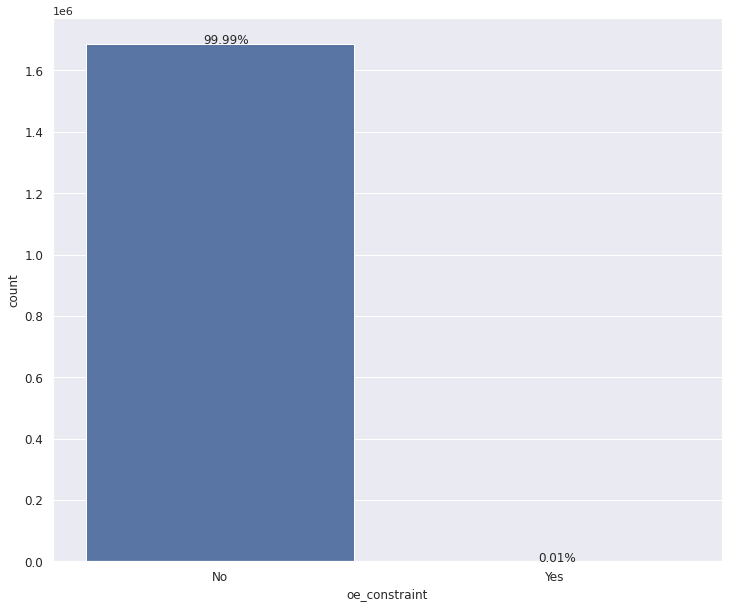

In [ ]:
feature = "oe_constraint"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- 99.99% of data points have 'oe_constraint' flag as 'No'.
- 0.01% of data points have 'oe_constraint' flag as 'Yes'.
- There is imbalance in the distribution of points for the two values of 'oe_constraint'.

In [ ]:
train["oe_constraint"].value_counts()

No     1687615
Yes        245
Name: oe_constraint, dtype: int64

#### 3.5.2.5. Categorical Featuere: ppap_risk

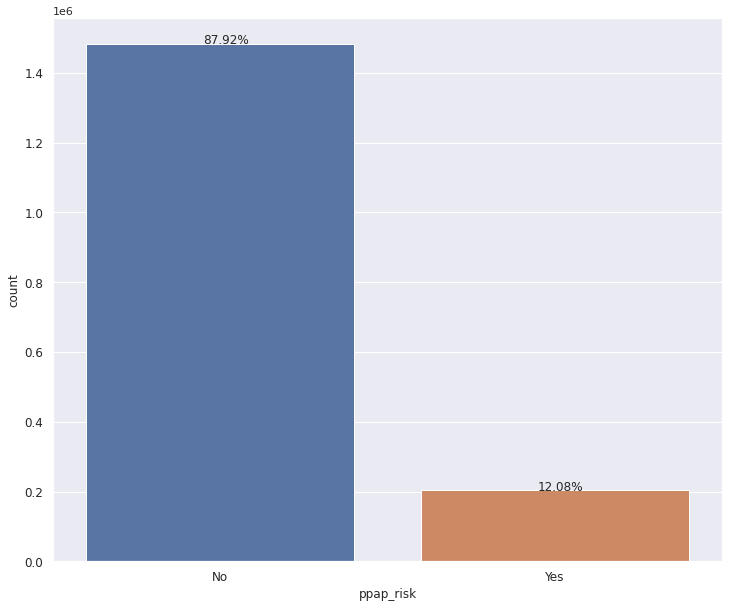

In [ ]:
feature = "ppap_risk"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- 87.92% of data points have 'ppap_risk' flag as 'No'.
- 12.08% of data points have 'ppap_risk' flag as 'Yes'.
- There is imbalance in the distribution of points for the two values of 'ppap_risk'.

In [ ]:
train["ppap_risk"].value_counts()

No     1484026
Yes     203834
Name: ppap_risk, dtype: int64

#### 3.5.2.6. Categorical Featuere: stop_auto_buy

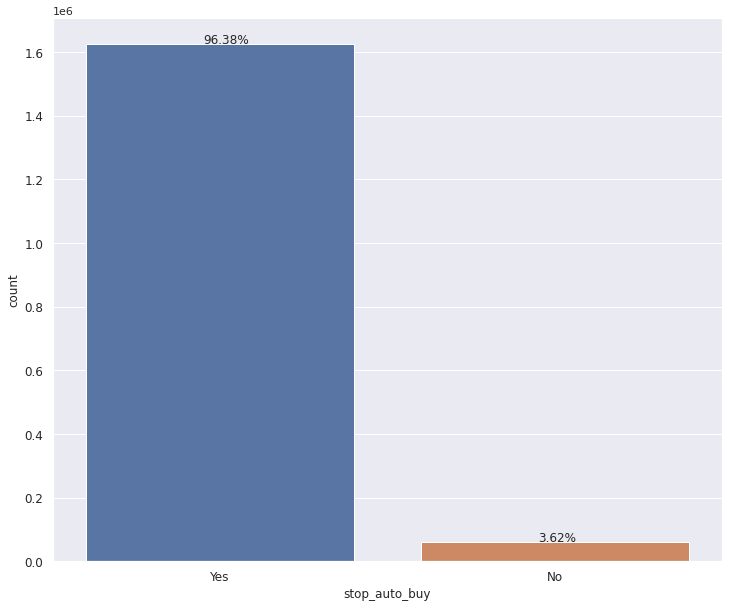

In [ ]:
feature = "stop_auto_buy"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- 96.38% of data points have 'stop_auto_buy' flag as 'Yes'.
- 3.62% of data points have 'stop_auto_buy' flag as 'No'.
- There is imbalance in the distribution of points for the two values of 'stop_auto_buy'.

In [ ]:
train["stop_auto_buy"].value_counts()

Yes    1626774
No       61086
Name: stop_auto_buy, dtype: int64

#### 3.5.2.7. Categorical Featuere: rev_stop

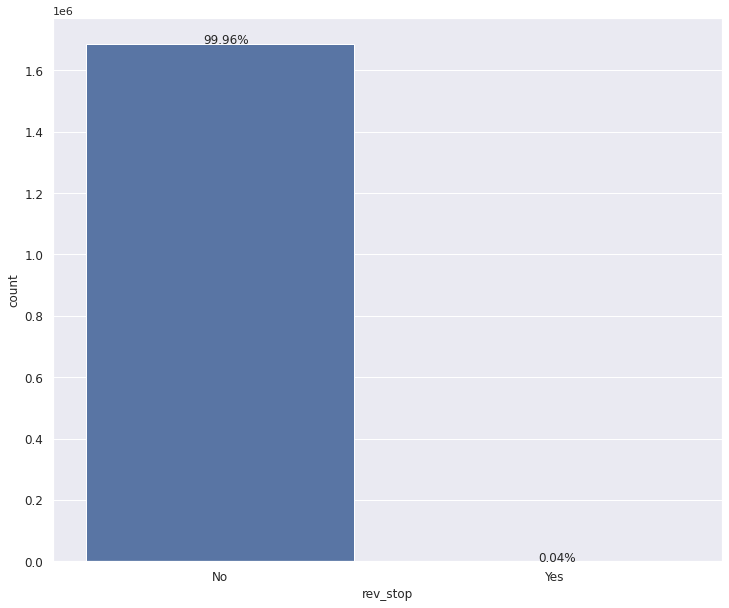

In [ ]:
feature = "rev_stop"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax, train[feature])

- 99.96% of data points have 'rev_stop' flag as 'No'.
- 0.04% of data points have 'rev_stop' flag as 'Yes'.
- There is imbalance in the distribution of points for the two values of 'rev_stop'.

In [ ]:
train["rev_stop"].value_counts()

No     1687129
Yes        731
Name: rev_stop, dtype: int64

#### 3.5.2.8. Correlation between Categorical Features: chisquare test

In [ ]:
# referred from https://stackoverflow.com/a/48035423
df = categorical_features.drop(['went_on_backorder', 'sku'], axis=1)
df=df.apply(lambda x : pd.factorize(x)[0])+1

pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in df], columns=df.columns, index=df.columns)

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
potential_issue,0.0,194278.0,1019.0,102489.5,31427.5,1272.5
deck_risk,387566.0,0.0,387517.0,406313.5,369156.0,387790.0
oe_constraint,688.0,193898.0,0.0,102081.0,30788.0,610.5
ppap_risk,203953.0,314489.0,203875.5,0.0,218172.5,203727.0
stop_auto_buy,61517.0,205957.5,61208.5,146798.5,0.0,60919.0
rev_stop,1184.5,194414.0,853.5,102175.5,30741.5,0.0


- There could be some correlation between 'potential_issue' and 'oe_constraint'.
- There could be some correlation between 'rev_stop' and 'oe_constraint'.
- There could be some correlation between 'rev_stop' and 'potential_issue'.
- Although the scores are high, but comparatively scores of above features are the lowest.

## 3.6. Bivariate Analysis
Here we will analayise each features with the target variable

### 3.6.1. Numeric Features vs Target variable

#### 3.6.1.1. 'national_inv' vs 'went_on_backorder'

##### Count plot of 'national_inv' vs 'went_on_backorder'

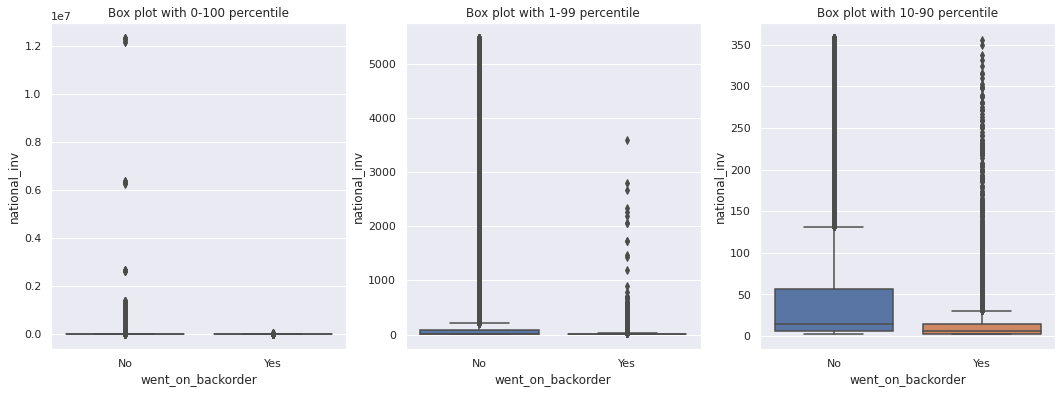

In [ ]:
feature = 'national_inv'
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y="national_inv", data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y="national_inv", data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y="national_inv", data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- IQR appear to be small for 'Yes' class and large for 'No' class.
- For both the classes, IQR is overlapping. Median values are different. This featuer could help in classifying whether or not product went to backorder.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.2. 'lead_time' vs 'went_on_backorder'

##### Count plot of 'lead_time' vs 'went_on_backorder'

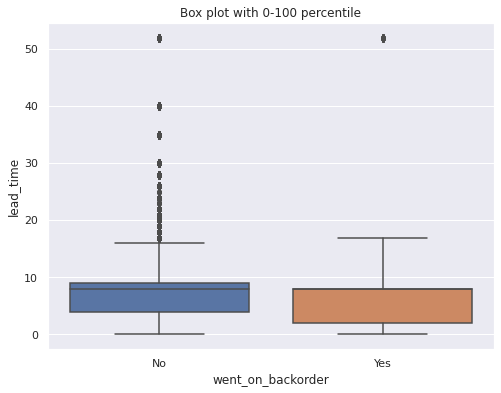

In [ ]:
feature = "lead_time"
x = train[feature]
f, axes = plt.subplots(figsize=(8,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR is overlapping. Hence, this feature doesn't seem helpful for classification.
- There seems to be a problem of outlier for the minority class 'No'.
- This feature also has missing values.

#### 3.6.1.3. 'in_transit_qty' vs 'went_on_backorder'

##### Count plot of 'in_transit_qty' vs 'went_on_backorder'

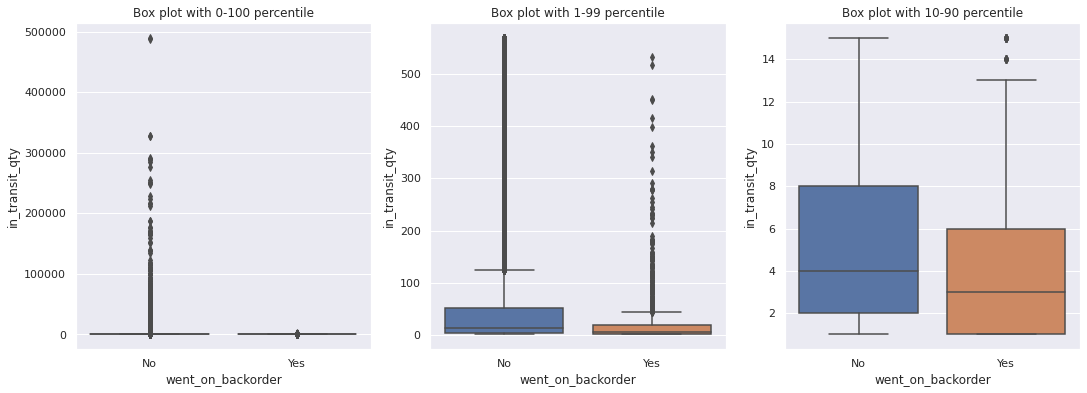

In [ ]:
feature = "in_transit_qty"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR is overlapping. Median values are different. This featuer could help in classifying whether or not product went to backorder.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.4. 'forecast_3_month' vs 'went_on_backorder'

##### Count plot of 'forecast_3_month' vs 'went_on_backorder'

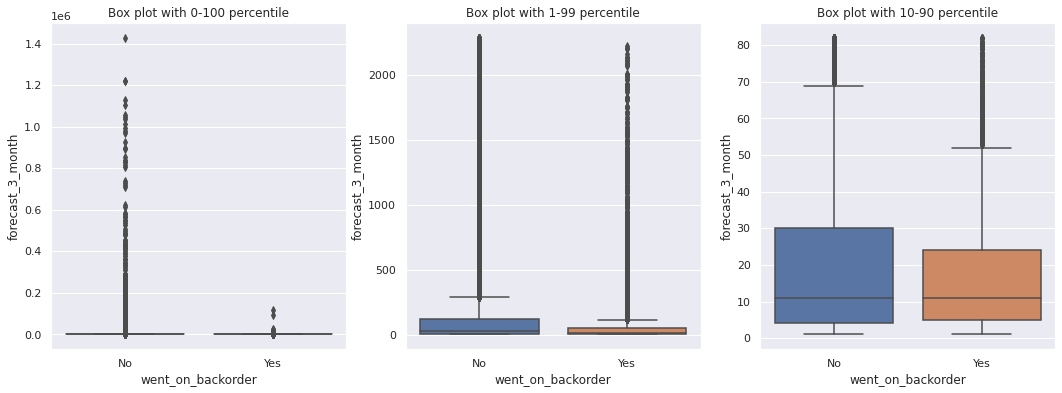

In [ ]:
feature = "forecast_3_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be medium.
- For both the classes, IQR is overlapping. Median values also appears to be almost same. Hence, this feature doesn't seem helpful for classification.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.5. 'forecast_6_month' vs 'went_on_backorder'

##### Count plot of 'forecast_6_month' vs 'went_on_backorder'

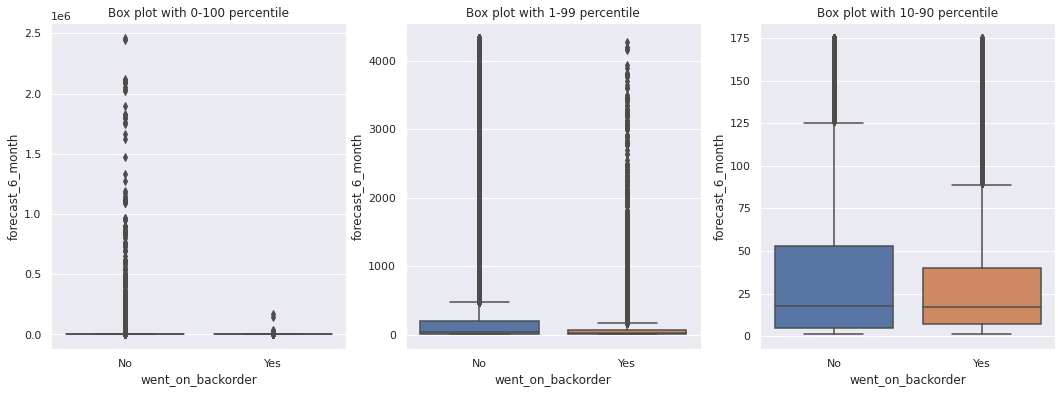

In [ ]:
feature = "forecast_6_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be medium.
- For both the classes, IQR is overlapping. Median values also appears to be almost same. Hence, this feature doesn't seem helpful for classification.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.6. 'forecast_9_month' vs 'went_on_backorder'

##### Count plot of 'forecast_9_month' vs 'went_on_backorder'

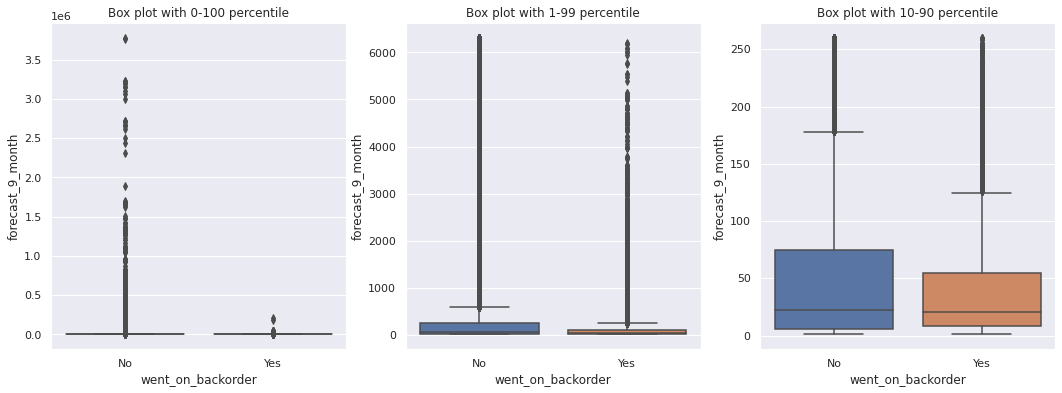

In [ ]:
feature = "forecast_9_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be large.
- For both the classes, IQR is overlapping. Median values also appears to be almost same. Hence, this feature doesn't seem helpful for classification.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.7. 'sales_1_month' vs 'went_on_backorder'

##### Count plot of 'sales_1_month' vs 'went_on_backorder'

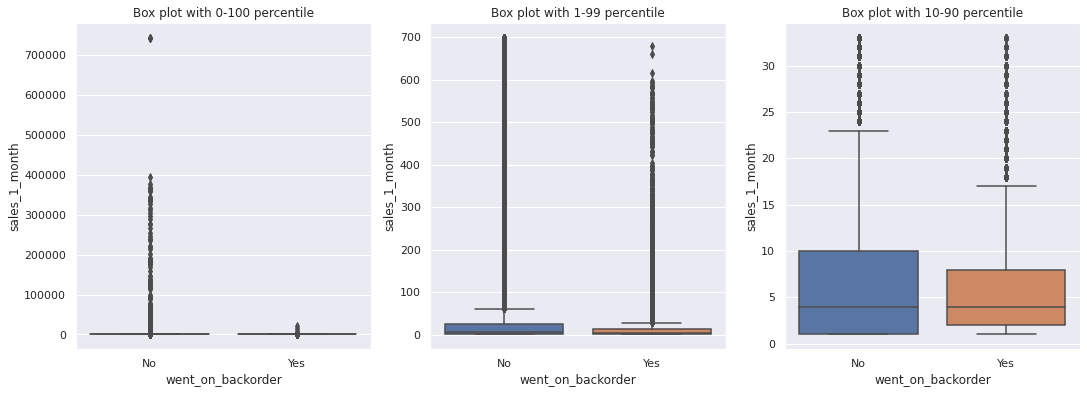

In [ ]:
feature = "sales_1_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR is overlapping. Median values also overlapping. Hence, this feature doesn't seems helpful for determing whether product went to backorder or not,
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.8. 'sales_3_month' vs 'went_on_backorder'

##### Count plot of 'sales_3_month' vs 'went_on_backorder'

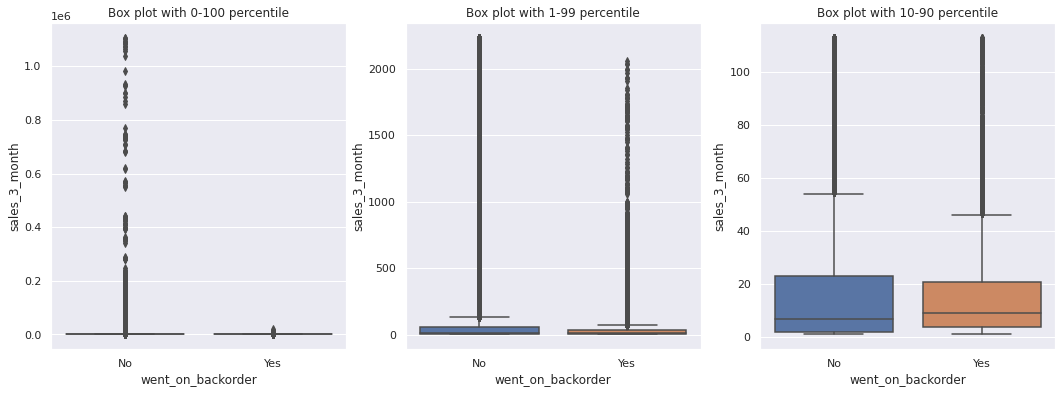

In [ ]:
feature = "sales_3_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR is overlapping. Median values appears to be different. Hence, this feature could be helpful in classification.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.9. 'sales_6_month' vs 'went_on_backorder'

##### Count plot of 'sales_6_month' vs 'went_on_backorder'

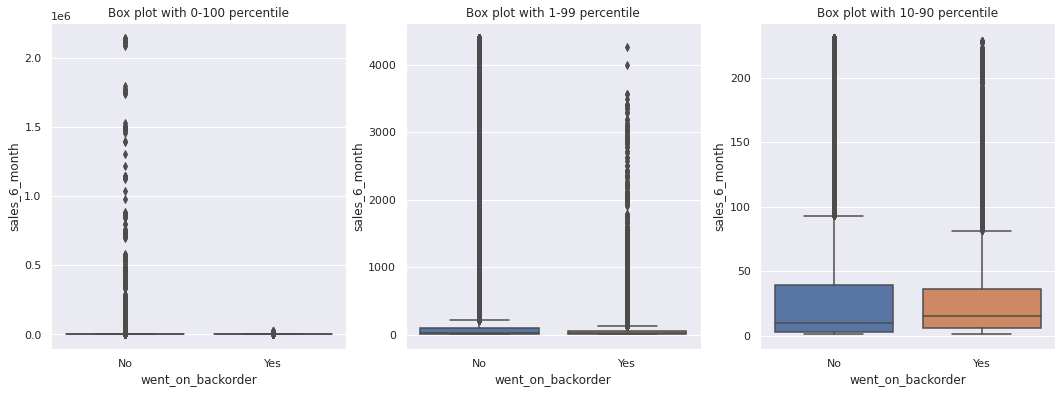

In [ ]:
feature = "sales_6_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR is overlapping. Median values appears to be different. Hence, this feature could be helpful in classification.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.10. 'sales_9_month' vs 'went_on_backorder'

##### Count plot of 'sales_9_month' vs 'went_on_backorder'

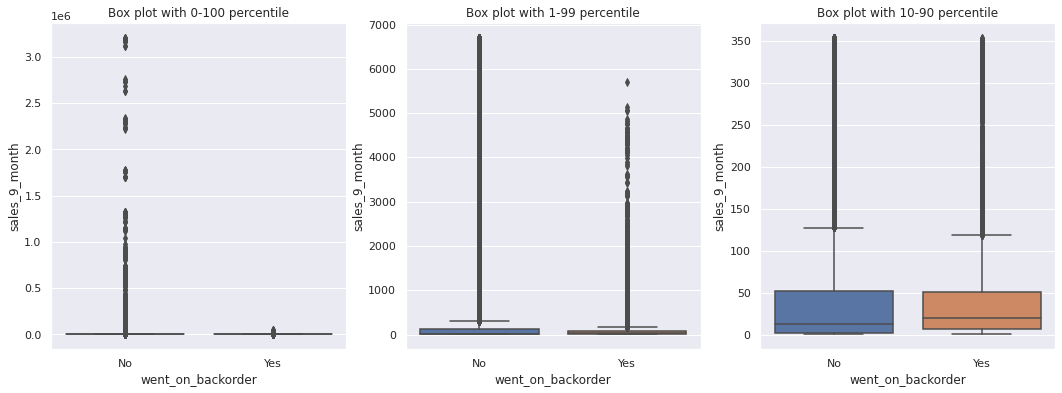

In [ ]:
feature = "sales_9_month"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be medium.
- For both the classes, IQR is overlapping. Median values appears to be different. Hence, this feature could be helpful in classification.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.11. 'min_bank' vs 'went_on_backorder'

##### Count plot of 'min_bank' vs 'went_on_backorder'

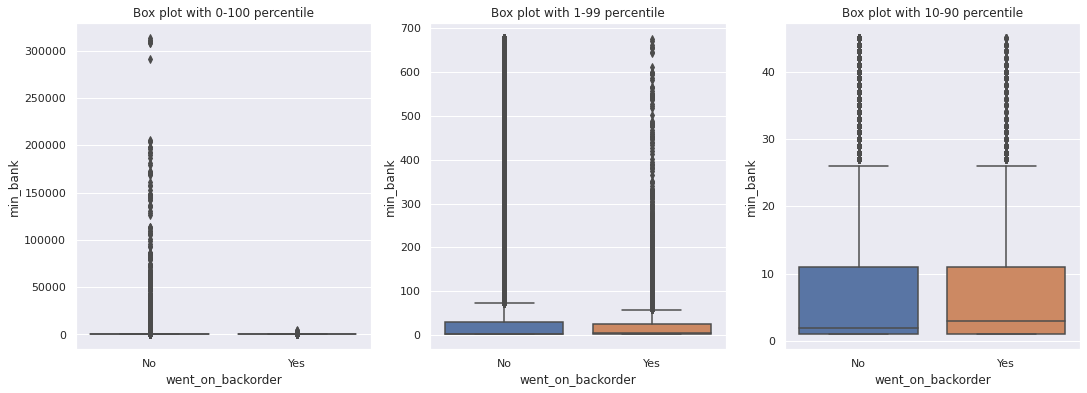

In [ ]:
feature = "min_bank"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

df2 = feature_percentile_dataframe(10,90,feature,train)
x2 = df2[feature]

f, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
sns.boxplot(x='went_on_backorder', y=feature, data=df2,  orient='v' , ax=axes[2])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')
axes[2].title.set_text('Box plot with 10-90 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR is overlapping. Median values although different but appears to be close. Hence, this feature will not be helpful in differentiating classes.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.12. 'pieces_past_due' vs 'went_on_backorder'

##### Count plot of 'pieces_past_due' vs 'went_on_backorder'

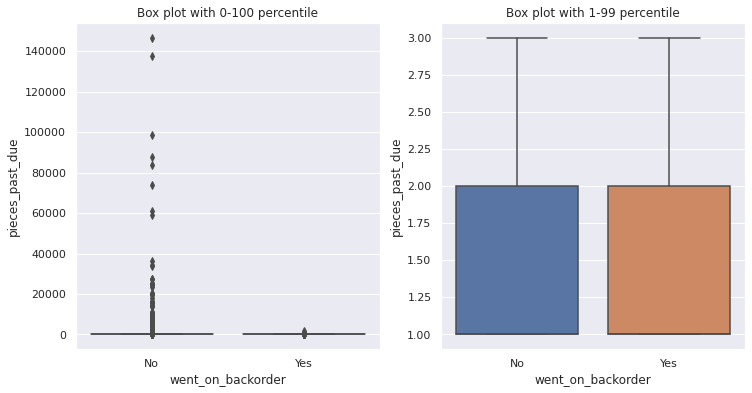

In [ ]:
feature = "pieces_past_due"
x = train[feature]

df1 = feature_percentile_dataframe(1,99,feature,train)
x1 = df1[feature]

f, axes = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes[0])
sns.boxplot(x='went_on_backorder', y=feature, data=df1,  orient='v' , ax=axes[1])
axes[0].title.set_text('Box plot with 0-100 percentile')
axes[1].title.set_text('Box plot with 1-99 percentile')

- For both the classes, IQR appear to be very small.
- For both the classes, IQR is overlapping completely. Hence, this feature is not helpful in classification. 
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.13. 'perf_6_month_avg' vs 'went_on_backorder'

##### Count plot of 'perf_6_month_avg' vs 'went_on_backorder'

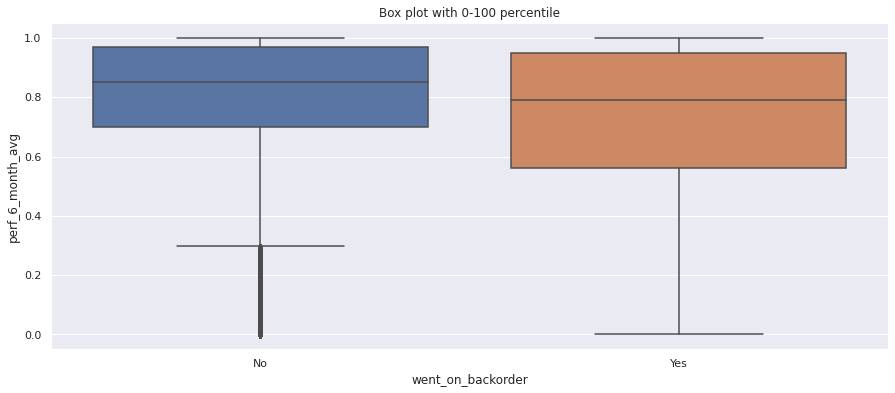

In [ ]:
feature = "perf_6_month_avg"
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- For both the classes, IQR appear to be very small.
- For both the classes, IQR is overlapping. But median values are different for each class, also lower percentile is much lower for 'Yes' class then 'No' class. Hence could be somewhat helpful in differentiating.
- There seems to be a problem of outlier for the minority class 'No'.
- This feature also has missing values.

#### 3.6.1.14. 'perf_12_month_avg' vs 'went_on_backorder'

##### Count plot of 'perf_12_month_avg' vs 'went_on_backorder'

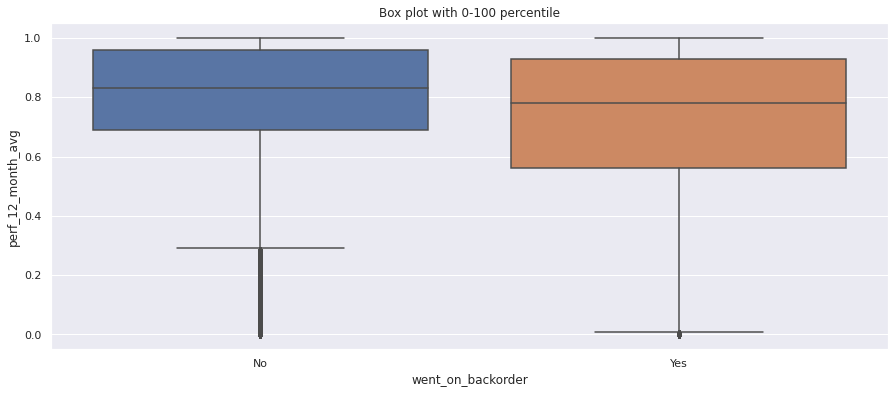

In [ ]:
feature = "perf_12_month_avg"
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- For both the classes, IQR appear to be very small.
- For both the classes, IQR is overlapping. But median values are different for each class, also lower percentile is much lower for 'Yes' class then 'No' class. Hence could be somewhat helpful in differentiating.
- There seems to be a problem of outlier for the minority class 'No'.

#### 3.6.1.15. 'local_bo_qty' vs 'went_on_backorder'

##### Count plot of 'local_bo_qty' vs 'went_on_backorder'

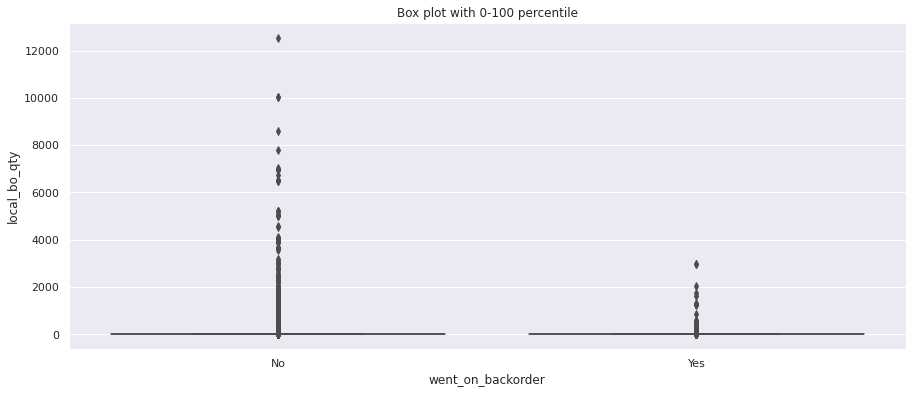

In [ ]:
feature = "local_bo_qty"
x = train[feature]
f, axes = plt.subplots(figsize=(15,6))
sns.boxplot(x='went_on_backorder', y=feature, data=train,  orient='v' , ax=axes)
axes.title.set_text('Box plot with 0-100 percentile')

- For both the classes, IQR appear to be small.
- For both the classes, IQR seems to similar. Hence can't differentiate as it is.
- There seems to be a problem of outlier for the minority class 'No'.
- This feature also has missing values.

### 3.6.2. Categorical Features vs Target Variable

#### 3.6.2.1. 'potential_issue' vs 'went_on_backorder'

##### Count plot of 'potential_issue' vs 'went_on_backorder'

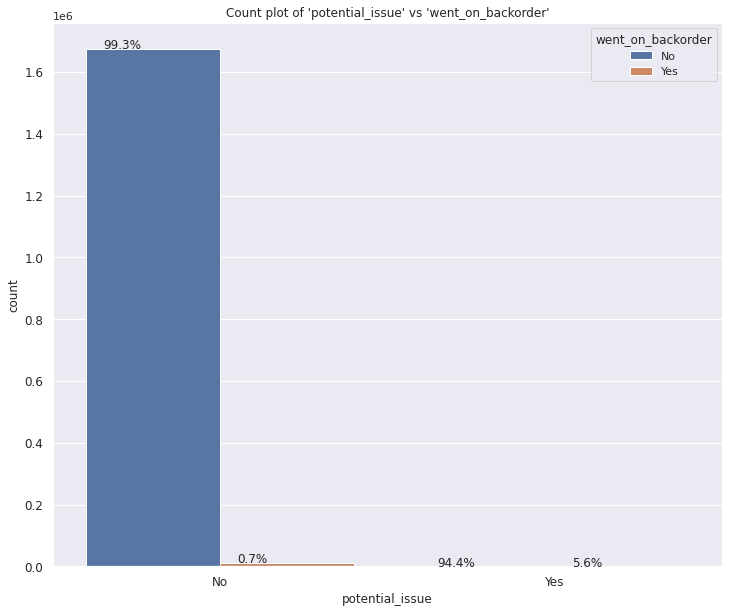

In [ ]:
feature = "potential_issue"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, hue = 'went_on_backorder', data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
plt.title("Count plot of 'potential_issue' vs 'went_on_backorder'")

with_hue(ax, train[feature], 2, 2)

- When 'potential_issue' is 'No', 0.7% products went to backorder.
- When 'potential_issue' is 'Yes', 5.6% products went to backorder.
- When 'potential_issue' is 'Yes', there 8 times more probability of product going to backorder.

#### 3.6.2.2. 'deck_risk' vs 'went_on_backorder'

##### Count plot of 'deck_risk' vs 'went_on_backorder'

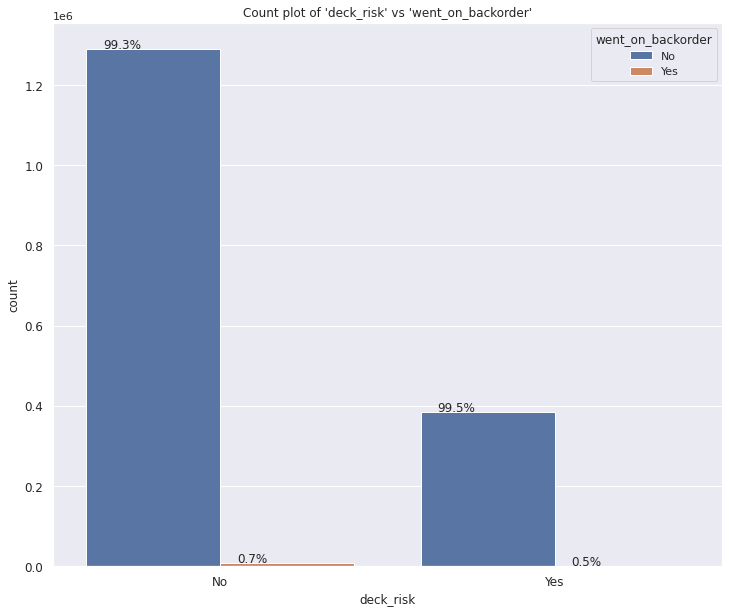

In [ ]:
feature = "deck_risk"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, hue = 'went_on_backorder', data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
plt.title("Count plot of 'deck_risk' vs 'went_on_backorder'")

with_hue(ax, train[feature], 2, 2)

- When 'deck_risk' is 'No', 0.7% products went to backorder.
- When 'deck_risk' is 'Yes', 0.5% products went to backorder.
- Since distribution of points, when product went to backorder is almost similar in this case, this feature doesn't seem helpful in determining whether or not product went ot backorder.


#### 3.6.2.3. 'oe_constraint' vs 'went_on_backorder'

##### Count plot of 'oe_constraint' vs 'went_on_backorder'

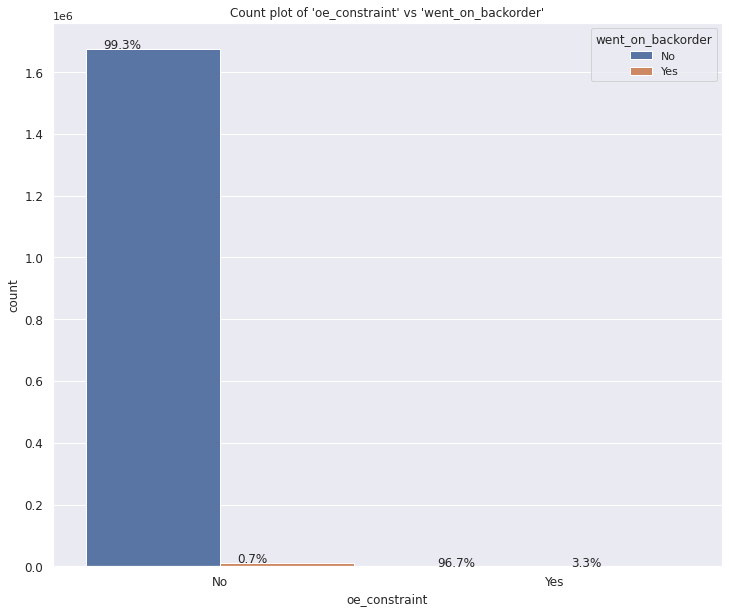

In [ ]:
feature = "oe_constraint"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, hue = 'went_on_backorder', data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
plt.title("Count plot of 'oe_constraint' vs 'went_on_backorder'")

with_hue(ax, train[feature], 2, 2)

- When 'oe_constraint' is 'No', 0.7% products went to backorder.
- When 'oe_constraint' is 'Yes', 3.3% products went to backorder.
- So, it means it 'oe_constraint' value is 'Yes' there are approx 5% more probability of product going to backorder. Hence, this feature is important.

#### 3.6.2.4. 'ppap_risk' vs 'went_on_backorder'

##### Count plot of 'ppap_risk' vs 'went_on_backorder'

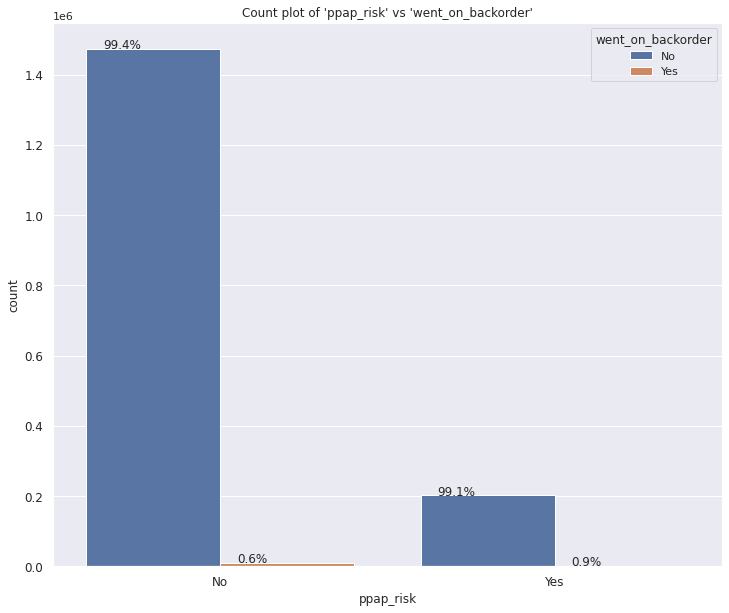

In [ ]:
feature = "ppap_risk"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, hue = 'went_on_backorder', data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
plt.title("Count plot of 'ppap_risk' vs 'went_on_backorder'")

with_hue(ax, train[feature], 2, 2)

- When 'ppap_risk' is 'No', 0.6% of product goes to backorder.
- When 'ppap_risk' is 'Yes', 0.9% of product goes to backorder.
- This feature also doesn't seem to be helpful as it is not providing much distinction between product went to backorder or not.

#### 3.6.2.5. 'stop_auto_buy' vs 'went_on_backorder'

##### Count plot of 'stop_auto_buy' vs 'went_on_backorder'

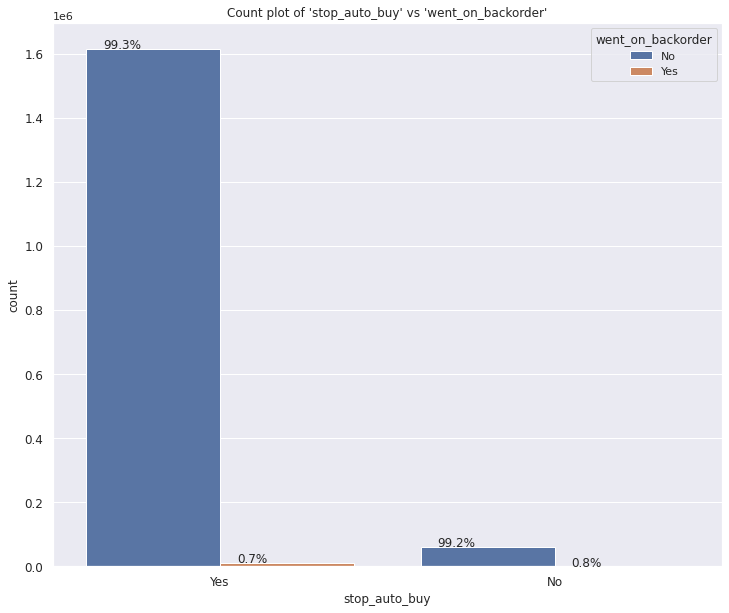

In [ ]:
feature = "stop_auto_buy"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, hue = 'went_on_backorder', data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
plt.title("Count plot of 'stop_auto_buy' vs 'went_on_backorder'")

with_hue(ax, train[feature], 2, 2)

- When 'stop_auto_buy' was 'Yes', about 0.7% of the products went to backorder.
- When 'stop_auto_buy' was 'No', about 0.8% of the products went to backorder.
- This feature is not helping much in classification, as it have almost equal distribution of points.

#### 3.6.2.6. 'rev_stop' vs 'went_on_backorder'

##### Count plot of 'rev_stop' vs 'went_on_backorder'

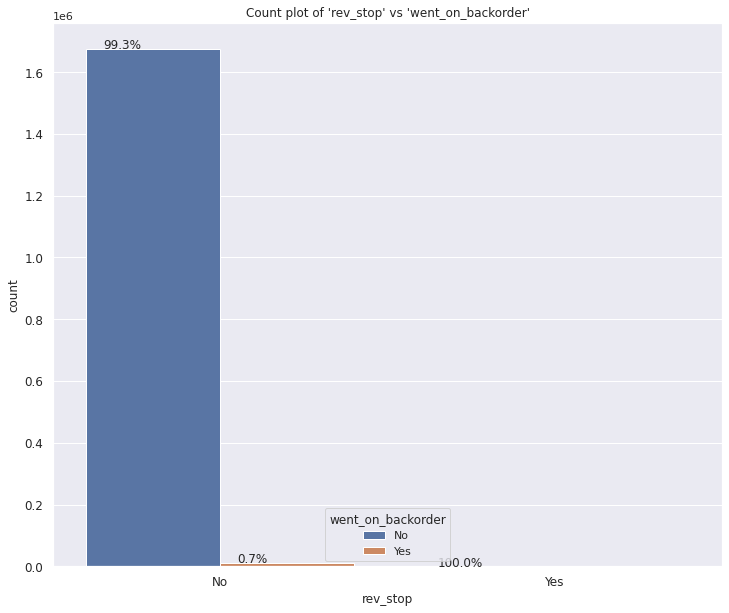

In [ ]:
feature = "rev_stop"
plt.figure(figsize=(12,10))
ax=sns.countplot(x= feature, hue = 'went_on_backorder', data=train)
plt.xticks(size=12)
plt.xlabel(feature,size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
plt.title("Count plot of 'rev_stop' vs 'went_on_backorder'")

with_hue(ax, train[feature], 2, 2)

- When 'rev_stop' is 'Yes', no product went ot backorder.
- When 'rev_stop' is 'No', about 0.7% of products went to backorder.
- This feature could be helpful in classification, as products goes to backorder when it set to 'No' only.

#### 3.6.2.7. Correlation between categorical features and target variable

In [ ]:
# referred from https://stackoverflow.com/a/48035423
df = categorical_features.drop(['sku'], axis=1)
df=df.apply(lambda x : pd.factorize(x)[0])+1

pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in ['went_on_backorder']], columns=df.columns, index=['went_on_backorder'])

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
went_on_backorder,11670.0,202160.5,11403.5,110571.5,41129.5,11658.5,0.0


- The features doesn't seems to be much correlated to the target variable individually.

# 4. Feature Engineering

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1687860 non-null  float64
 1   lead_time          1586967 non-null  float64
 2   in_transit_qty     1687860 non-null  float64
 3   forecast_3_month   1687860 non-null  float64
 4   forecast_6_month   1687860 non-null  float64
 5   forecast_9_month   1687860 non-null  float64
 6   sales_1_month      1687860 non-null  float64
 7   sales_3_month      1687860 non-null  float64
 8   sales_6_month      1687860 non-null  float64
 9   sales_9_month      1687860 non-null  float64
 10  min_bank           1687860 non-null  float64
 11  potential_issue    1687860 non-null  object 
 12  pieces_past_due    1687860 non-null  float64
 13  perf_6_month_avg   1558382 non-null  float64
 14  perf_12_month_avg  1565810 non-null  float64
 15  local_bo_qty       1687860 non-n

## 4.1. Converting values of categorical features from 'No' and 'Yes' to 0 and 1

In [ ]:
# Change categorical features from string to numerical
cat_cols = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
for col_name in cat_cols:
    train[col_name] = train[col_name].map({'No':0.0, 'Yes':1.0})
    #test[col_name] = test[col_name].map({'No':0, 'Yes':1})

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1687860 non-null  float64
 1   lead_time          1586967 non-null  float64
 2   in_transit_qty     1687860 non-null  float64
 3   forecast_3_month   1687860 non-null  float64
 4   forecast_6_month   1687860 non-null  float64
 5   forecast_9_month   1687860 non-null  float64
 6   sales_1_month      1687860 non-null  float64
 7   sales_3_month      1687860 non-null  float64
 8   sales_6_month      1687860 non-null  float64
 9   sales_9_month      1687860 non-null  float64
 10  min_bank           1687860 non-null  float64
 11  potential_issue    1687860 non-null  float64
 12  pieces_past_due    1687860 non-null  float64
 13  perf_6_month_avg   1558382 non-null  float64
 14  perf_12_month_avg  1565810 non-null  float64
 15  local_bo_qty       1687860 non-n

## 4.2. Train Test Split

In [ ]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, test_size = 0.2, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((1350288, 21), (337572, 21))

## 4.3. Missing Value Imputation

### IterativeImputer

In [ ]:
X_train_iter = X_train.copy()
X_test_iter = X_test.copy()
imp1 = IterativeImputer(max_iter=10, random_state=10)
imp1.fit(X_train_iter)
X_train_iter[:] = imp1.transform(X_train_iter)
X_test_iter[:] = imp1.transform(X_test_iter)

## 4.4. Feature Importance using PCA

In [ ]:
# https://pypi.org/project/pca/
model = pca()
X = X_train_iter.copy()
out = model.fit_transform(X)
print(out['topfeat'])

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [21] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [2] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
      PC            feature   loading  type
0    PC1       national_inv  0.971436  best
1    PC2   forecast_9_month  0.559187  best
2    PC3      sales_9_month -0.615937  best
3    PC4      sales_6_month -0.594502  best
4    PC5   forecast_3_month  0.510635  best
5    PC6     in_transit_qty  0.881047  best
6    PC7      sales_1_month  0.600598  best
7    PC8      sales_3_month  0.648945  best
8    PC9           min_bank -0.753766  best
9   PC10   forecast_6_month  0.679198  best
10  PC11    pieces_past_due  0.998755  best

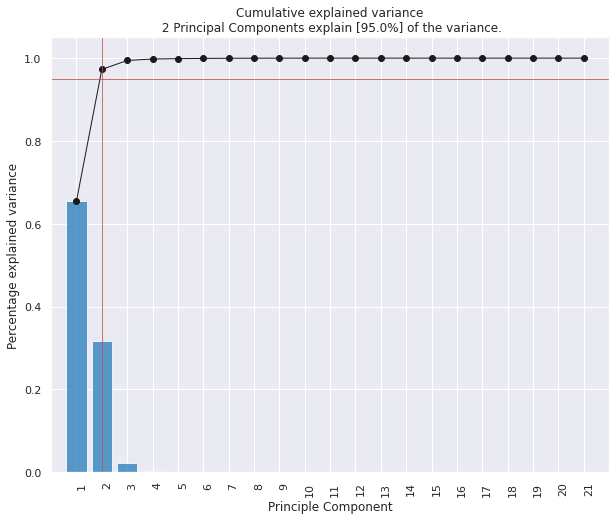

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 2 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot of explained variance vs features
model.plot()

- The top three features in our PCA analysis are: 'national_inv', 'forecast_9_month' and 'sales_9_month'

## 4.5. Correaltion between numeric features and target variable using Point Biserial correlation

In [ ]:
print('Correlation between numeric features and target variable')
for col in numeric_columns:
  a = y_train
  b = X_train_iter[col]
  corr_ = scipy.stats.pointbiserialr(a, b)
  print('{} and {} - {}'.format(col, 'went_on_backorder', corr_))

Correlation between numeric features and target variable
national_inv and went_on_backorder - PointbiserialrResult(correlation=-0.0012441913453430627, pvalue=0.14824084776230778)
lead_time and went_on_backorder - PointbiserialrResult(correlation=-0.018142329865244784, pvalue=1.1285890734951374e-98)
in_transit_qty and went_on_backorder - PointbiserialrResult(correlation=-0.0024593248654882277, pvalue=0.004266110443474301)
forecast_3_month and went_on_backorder - PointbiserialrResult(correlation=-0.00018926436587514623, pvalue=0.8259267820442655)
forecast_6_month and went_on_backorder - PointbiserialrResult(correlation=-0.0007287474341123539, pvalue=0.39709677229314755)
forecast_9_month and went_on_backorder - PointbiserialrResult(correlation=-0.000936538142668886, pvalue=0.2764740397206987)
sales_1_month and went_on_backorder - PointbiserialrResult(correlation=-0.0010425183959958996, pvalue=0.22573243972392734)
sales_3_month and went_on_backorder - PointbiserialrResult(correlation=-0.00

- 'local_bo_qty' and 'pieces_past_due' are the only features which are positively correlated with the target variable.
- Rest all the features are negatively correlated with the target variable.
- Most of the correlations does not seem to be that significant. 

## 4.6. Feature Transformation

### 4.6.1. Raw Data + Robust Scaling

In [ ]:
X_train_iter_robust = X_train_iter.copy()
X_test_iter_robust = X_test_iter.copy()
scaler = RobustScaler()
scaler.fit(X_train_iter_robust)
X_train_iter_robust[:] = scaler.transform(X_train_iter_robust)
X_test_iter_robust[:] = scaler.transform(X_test_iter_robust)

### 4.6.2. Log Transformation and Standard Scaling

In [ ]:
skewed = ['national_inv','lead_time', 'in_transit_qty' , 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month' , 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']

In [ ]:
log_columns = []
for i in skewed:
  log_columns.append(X_train.columns.get_loc(i))

In [ ]:
def log_transform(a):
  sign = np.sign(a[log_columns])
  a[log_columns] =  np.log(1.0+abs(a[log_columns]))*sign
  return a

In [ ]:
X_train_iter_log = X_train_iter.copy()
X_test_iter_log = X_test_iter.copy()
X_train_iter_log[:] = np.apply_along_axis(log_transform, 1, X_train_iter_log)
X_test_iter_log[:] = np.apply_along_axis(log_transform, 1, X_test_iter_log)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_iter_log)
X_train_iter_log[:] = scaler.transform(X_train_iter_log)
X_test_iter_log[:] = scaler.transform(X_test_iter_log)

### 4.6.3. Quantile Transformer

In [ ]:
X_train_iter_quantile = X_train_iter.copy()
X_test_iter_quantile = X_test_iter.copy()
scaler = QuantileTransformer(output_distribution='normal')
scaler.fit(X_train_iter_quantile)
X_train_iter_quantile[:] = scaler.transform(X_train_iter_quantile)
X_test_iter_quantile[:] = scaler.transform(X_test_iter_quantile)

### 4.6.4. Max Absolute Scaling

In [ ]:
X_train_iter_maxabs = X_train_iter.copy()
X_test_iter_maxabs = X_test_iter.copy()
scaler = MaxAbsScaler()
scaler.fit(X_train_iter_maxabs)
X_train_iter_maxabs[:] = scaler.transform(X_train_iter_maxabs)
X_test_iter_maxabs[:] = scaler.transform(X_test_iter_maxabs)

### 4.6.5. Power Law Transformer

In [ ]:
X_train_iter_power = X_train_iter.copy()
X_test_iter_power = X_test_iter.copy()
scaler = PowerTransformer()
scaler.fit(X_train_iter_power)
X_train_iter_power[:] = scaler.transform(X_train_iter_power)
X_test_iter_power[:] = scaler.transform(X_test_iter_power)

# 5. Summary of EDA and Feature Engineering

- The dataset is a highly imbalanced dataset with 99.99% of points of majority(negative) class rest is minority(positive) class.
- The problem we are trying to address is a binary classification problem where we have to predict whether or not a product will go to backorder.
- In the dataset there are 15 numerical feature all of which are highly skewed.
- Three features have missing values - 'leat_time', 'perf_6_month_avg' and 'perf_12_month_avg'.
- 'perf_6_month_avg' and 'perf_12_month_avg' are the only two features which are heavily left skewed rest all the features are right skewed.
- All the numerical features have small IQR and some have negative values also which are valid entries.
- Features of sales, forecast and performance have a alot of correlations.
- There are 8 categorical features, out of which 'went_to_backorder' is the target variable and 'sku' is acting as the index.
- Most of the categorical features are highly imbalanced in their classes too.
- 'potential_issue', 'oe_constraint' and 'rev_stop' were the categorical features which seems helpful in the classification.
- As part of feature engineering first categorical features were converted to numerical features.
- Then dataset was split into train and test dataset with 80:20.
- After that IterativeImputer was used for missing value imputation.
- PCA was also performed to determine feature importance.
- 5 different types of feature transformation were applied on the dataset.
  - Robust Scaling
  - PowerLaw Transform
  - Log Transform
  - MaxAbs Scaling
  - Quantile Tranform

# 6. Baseline Model - Random Model

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_iter, y_train)
y_pred = dummy_clf.predict(X_test_iter)
y_scores = dummy_clf.predict_proba(X_test_iter)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9866
Recall Score:  0.0066
ROC AUC Score:  0.5005
Average Precision-Recall score:  0.0067


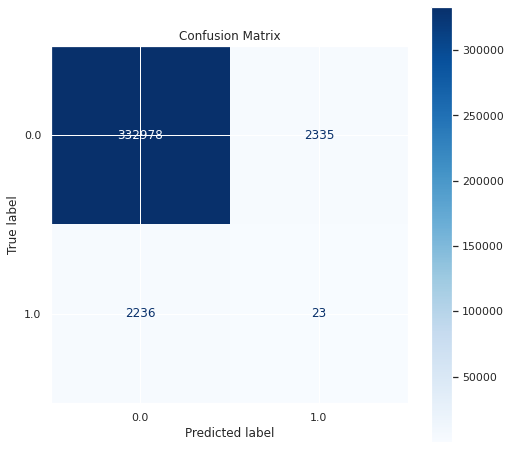

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(dummy_clf, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.5005')

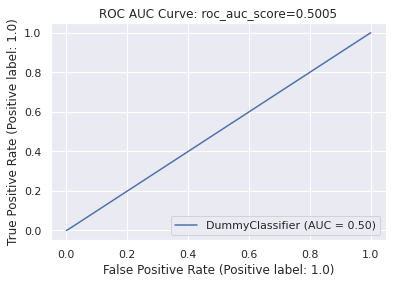

In [ ]:
disp = plot_roc_curve(dummy_clf, X_test_iter_robust, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0067')

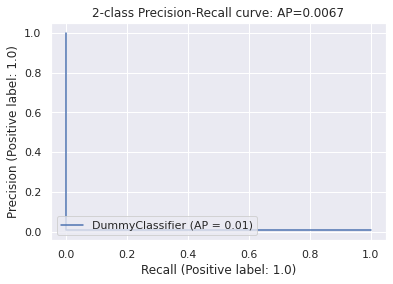

In [ ]:
disp = plot_precision_recall_curve(dummy_clf, X_test_iter_robust, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

# 7. Machine Learning Models

## 7.1. Robust Scaling

### 7.1.1. Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_iter_robust, y_train)

In [ ]:
Xsampled = pd.DataFrame(X_res, columns=X_train_iter_robust.columns)
Xsampled['went_on_backorder'] = y_res
Xsampled.to_csv('robust_randomundersampling.csv', index=False)

In [ ]:
df = pd.read_csv('robust_randomundersampling.csv')
X_res = df.drop(['went_on_backorder'], axis = 1)
y_res = df['went_on_backorder']

### 7.1.2. Logistic Regression

In [ ]:
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.1, 1.0, 10.0, 100.0, 1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'C': 0.1, 'penalty': 'l2'}
Best Score :  0.7559268208414174


In [ ]:
model = LogisticRegression(penalty = gs.best_params_['penalty'],C = gs.best_params_['C'],n_jobs=-1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_robust)
y_scores = model.predict_proba(X_test_iter_robust)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.7409
Recall Score:  0.6698
ROC AUC Score:  0.7701
Average Precision-Recall score:  0.0261


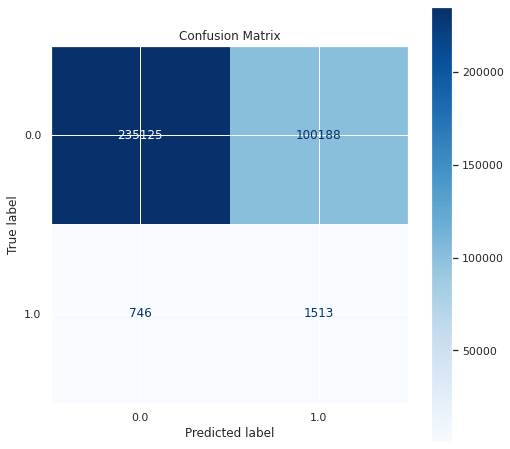

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.7701')

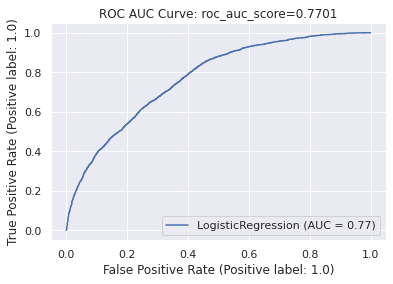

In [ ]:
disp = plot_roc_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0261')

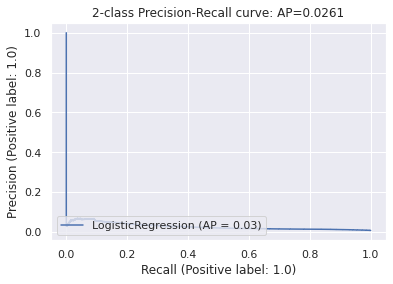

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.1.3. Decision Tree

In [ ]:
model = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'criterion': 'entropy', 'max_depth': 6}
Best Score :  0.9138014423779997


In [ ]:
model = DecisionTreeClassifier(criterion = gs.best_params_['criterion'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_robust)
y_scores = model.predict_proba(X_test_iter_robust)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8759
Recall Score:  0.869
ROC AUC Score:  0.9306
Average Precision-Recall score:  0.1132


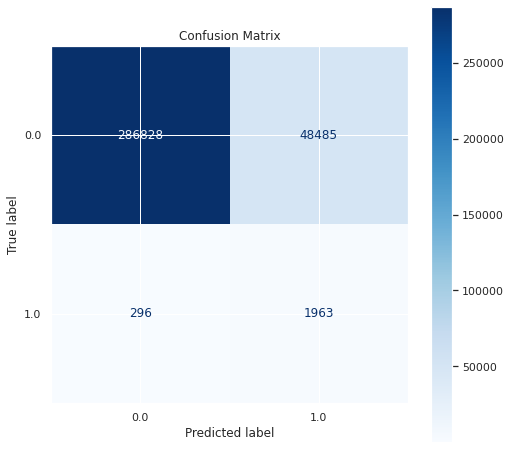

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9306')

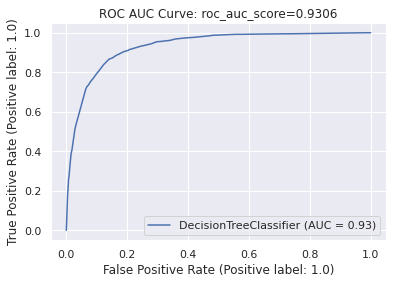

In [ ]:
disp = plot_roc_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1132')

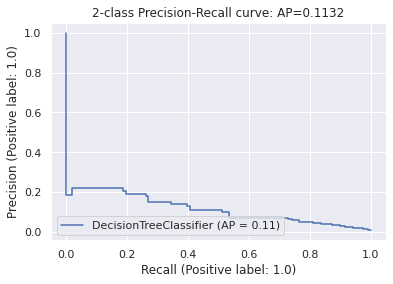

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.1.4. Random Forest

In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators': [100, 200], 'max_depth':[20,30,40,50,70,90,120,150]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 20, 'n_estimators': 200}
Best Score :  0.960772531579293


In [ ]:
model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_robust)
y_scores = model.predict_proba(X_test_iter_robust)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9041
Recall Score:  0.9433
ROC AUC Score:  0.9702
Average Precision-Recall score:  0.2583


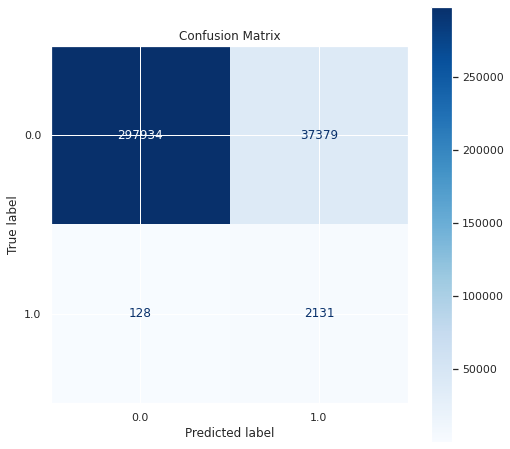

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9702')

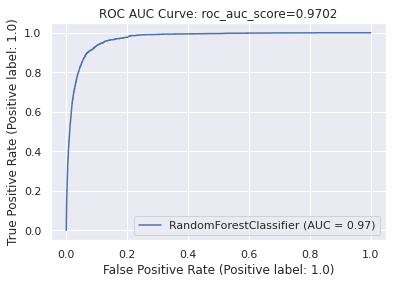

In [ ]:
disp = plot_roc_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2583')

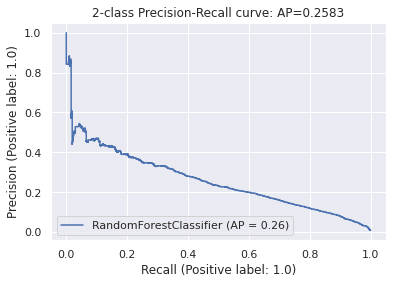

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.1.5. Xgboost

In [ ]:
model = XGBClassifier(n_jobs=-1, eval_metric='aucpr')
parameters = {'n_estimators': [100, 200,300], 'max_depth':[10,11,12,15,20,30,40,50]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 30, 'n_estimators': 100}
Best Score :  0.9563229408085284


In [ ]:
model = XGBClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1, eval_metric='aucpr')
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_robust)
y_scores = model.predict_proba(X_test_iter_robust)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.909
Recall Score:  0.9425
ROC AUC Score:  0.9685
Average Precision-Recall score:  0.2083


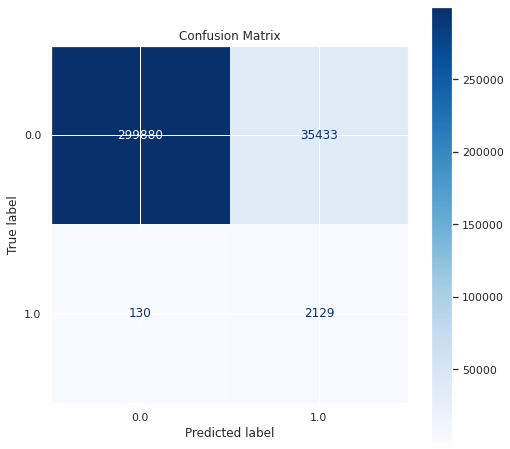

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9685')

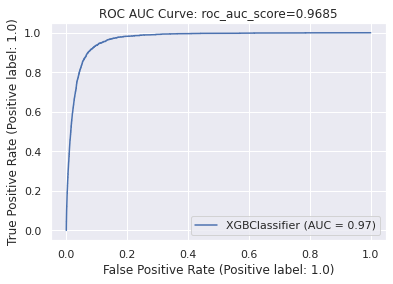

In [ ]:
disp = plot_roc_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2083')

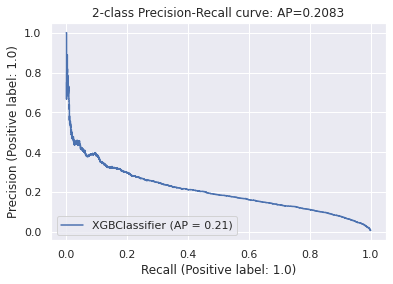

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_robust, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.1.6. Custom Ensemble

#### Utility Functions for custom ensemble model

In [ ]:
# Function that split dataset
def data_split(X,y):
  """
  This function takes X and y as input then split into train and test dataset with 80:20.
  It then again splits the train dataset into two parts with 50:50.
  """
  X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=11, test_size=0.20)
  X_D1, X_D2, y_D1, y_D2 = train_test_split(X_train, y_train, stratify=y_train, random_state=11, test_size=0.50)
  return X_test, y_test, X_D1, y_D1, X_D2, y_D2

# Function for preprocessing the datasets
def preprocessing_df(scaler, X_test, X_D1, X_D2):
  """
  This function will perform missing value imputations and feature scaling on the provided datasets.
  """
  imp = IterativeImputer(max_iter=10, random_state=10)
  imp.fit(X_D1)
  X_D1 = imp.transform(X_D1)
  X_D2 = imp.transform(X_D2)
  X_test = imp.transform(X_test)
  
  scaler = scaler
  scaler.fit(X_D1)
  X_D1 = scaler.transform(X_D1)
  X_D2 = scaler.transform(X_D2)
  X_test = scaler.transform(X_test)
  return X_D1, X_D2, X_test

# Function to perform random sampling of the dataset
def sampling_df_random(X_D1, y_D1, num_splits):
  """
  This function will create the random samples, specified by the user, of the dataset for training.
  """
  size = int(np.ceil(len(X_D1)/num_splits))
  X_sampled = []
  y_sampled = []
  for i in range(num_splits):
    idx_list = range(X_D1.shape[0])
    sampled_idx = np.random.choice(idx_list, size = size, replace=True)
    X_sampled.append(X_D1[sampled_idx])
    y_sampled.append(y_D1.values[sampled_idx])
  return X_sampled, y_sampled

# Function to perform balanced sampling of the dataset
def sampling_df_balanced(X_D1, y_D1, num_splits):
  """
  This function will create the balanced samples corresponding to the classes, specified by the user, of the dataset for training.
  """
  X_sampled = []
  y_sampled = []
  pos_idx = np.where(y_D1.values==1)[0]
  neg_idx = np.where(y_D1.values==0)[0]
  for i in range(num_splits):
    sampled_idx = []
    sampled_idx.extend(pos_idx)
    samples = np.random.choice(neg_idx, size = len(pos_idx), replace=True)
    sampled_idx.extend(samples)
    random.shuffle(sampled_idx)
    X_sampled.append(X_D1[sampled_idx])
    y_sampled.append(y_D1.values[sampled_idx])
  return X_sampled, y_sampled

# Function to perform training of base learners
def base_model_training(base_model, X_sampled, y_sampled, num_splits):
  """
  This function will train the base learners corresponding to each data sample.
  """
  base_models = []
  for i in range(num_splits):
    model = base_model
    X = X_sampled[i]
    y = y_sampled[i]
    model.fit(X,y)
    filename = 'model'+str(i+1)+'.pkl'
    base_models.append(filename)
    with open(filename, 'wb') as file:
      pickle.dump(model, file)
  return base_models

# Function to get predictions from the base learners
def base_model_predictions(base_models, X_D2, y_D2, num_splits):
  """
  This function will get the predictions from each base learner and will return a dataset of all the predictions and the true labels.
  """
  df = pd.DataFrame()
  for i in range(num_splits):
    with open(base_models[i], 'rb') as file:
      model = pickle.load(file)
    preds = model.predict(X_D2)
    col_name = 'model'+str(i+1)
    df[col_name] = preds
  df['y'] = y_D2.values
  return df

# Function to perform training of the meta model
def meta_model_training(meta_model, df):
  X = df.drop(['y'], axis=1)
  y = df['y']
  return meta_model.fit(X,y)

# Function to get predictions from the meta model
def meta_model_predictions(trained_meta_model, df):
  """
  This function will get the predictions from the meta model and return the average_precision score, predictions and predictions probabilities
  """
  X = df.drop(['y'], axis=1)
  y = df['y']
  y_pred = trained_meta_model.predict(X)
  y_scores = trained_meta_model.predict_proba(X)[:,1]
  average_precision = average_precision_score(y_test, y_scores)
  return average_precision, y_pred, y_scores

# Function that will perform the custom ensemble model training and predictions by using random sampling
def custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_test, y_D1, y_D2, y_test, scaler, num_splits):
  X_sampled, y_sampled = sampling_df_random(X_D1, y_D1, num_splits)
  base_models = base_model_training(base_model, X_sampled, y_sampled, num_splits)
  df = base_model_predictions(base_models, X_D2, y_D2, num_splits)
  trained_meta_model = meta_model_training(meta_model, df)
  df2 = base_model_predictions(base_models, X_test, y_test, num_splits)
  average_precision, y_pred, y_scores = meta_model_predictions(trained_meta_model, df2)
  return average_precision, y_pred, y_scores

# Function that will perform the custom ensemble model training and predictions by using balanced sampling
def custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_test, y_D1, y_D2, y_test, scaler, num_splits):
  X_sampled, y_sampled = sampling_df_balanced(X_D1, y_D1, num_splits)
  base_models = base_model_training(base_model, X_sampled, y_sampled, num_splits)
  df = base_model_predictions(base_models, X_D2, y_D2, num_splits)
  trained_meta_model = meta_model_training(meta_model, df)
  df2 = base_model_predictions(base_models, X_test, y_test, num_splits)
  average_precision, y_pred, y_scores = meta_model_predictions(trained_meta_model, df2)
  return average_precision, y_pred, y_scores

In [ ]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']
scaler = RobustScaler()
X_t, y_t, X_D1, y_D1, X_D2, y_D2 = data_split(X,y)
X_D1, X_D2, X_t = preprocessing_df(scaler, X_t, X_D1, X_D2)

#### 7.1.6.1. Random Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [25:14<00:00, 378.58s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 200


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9925
Recall Score:  0.0899
ROC AUC Score:  0.8352
Average Precision-Recall score:  0.245


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

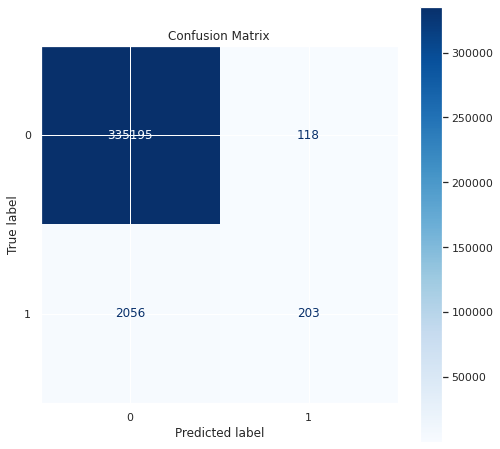

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax,values_format='d')

In [ ]:
from sklearn.metrics import roc_curve

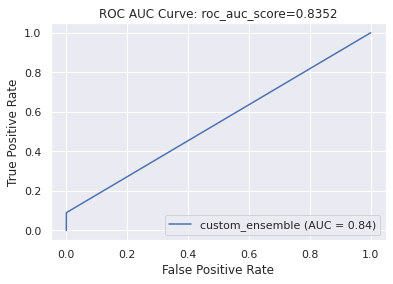

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

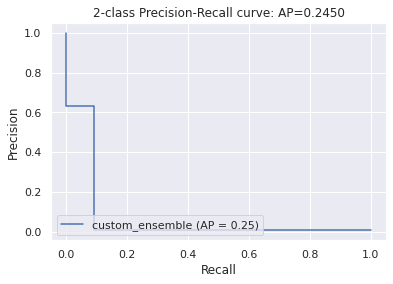

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax) 

#### 7.1.6.2. Balanced Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [30:47<00:00, 461.81s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 100


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.992
Recall Score:  0.0469
ROC AUC Score:  0.9347
Average Precision-Recall score:  0.2517


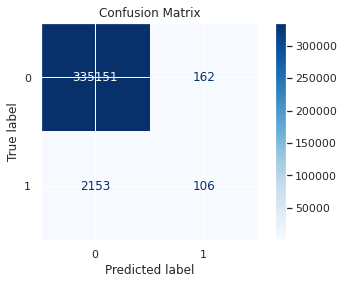

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

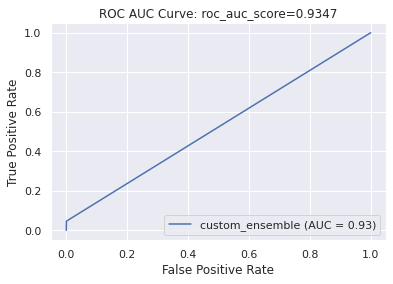

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

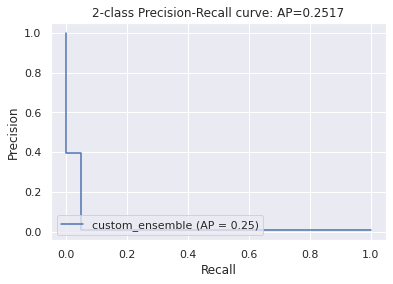

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

## 7.2. Power Transform

### 7.2.1. Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_iter_power, y_train)

In [ ]:
Xsampled = pd.DataFrame(X_res, columns=X_train_iter_power.columns)
Xsampled['went_on_backorder'] = y_res
Xsampled.to_csv('power_randomundersampling.csv', index=False)

In [ ]:
df = pd.read_csv('power_randomundersampling.csv')
X_res = df.drop(['went_on_backorder'], axis = 1)
y_res = df['went_on_backorder']

### 7.2.2. Logistic Regression

In [ ]:
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.1, 1.0, 10.0, 100.0, 1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'C': 1000.0, 'penalty': 'l2'}
Best Score :  0.879596800746083


In [ ]:
model = LogisticRegression(penalty = gs.best_params_['penalty'],C = gs.best_params_['C'],n_jobs=-1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_power)
y_scores = model.predict_proba(X_test_iter_power)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8536
Recall Score:  0.8336
ROC AUC Score:  0.8986
Average Precision-Recall score:  0.0732


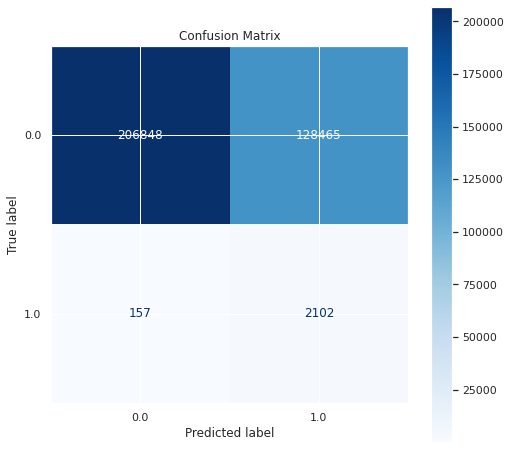

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.8986')

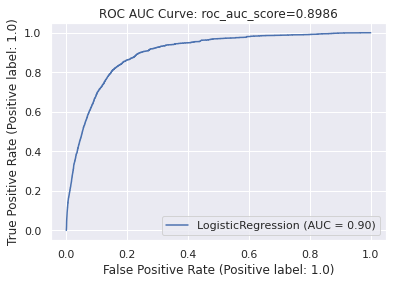

In [ ]:
disp = plot_roc_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0732')

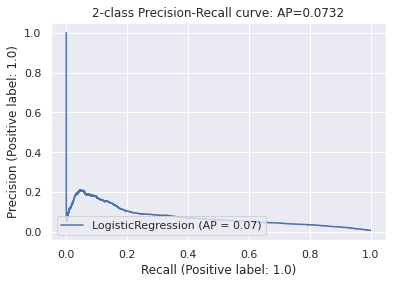

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.2.3. Decision Tree

In [ ]:
model = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'criterion': 'entropy', 'max_depth': 6}
Best Score :  0.9135996004378926


In [ ]:
model = DecisionTreeClassifier(criterion = gs.best_params_['criterion'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_power)
y_scores = model.predict_proba(X_test_iter_power)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8758
Recall Score:  0.8694
ROC AUC Score:  0.9307
Average Precision-Recall score:  0.1131


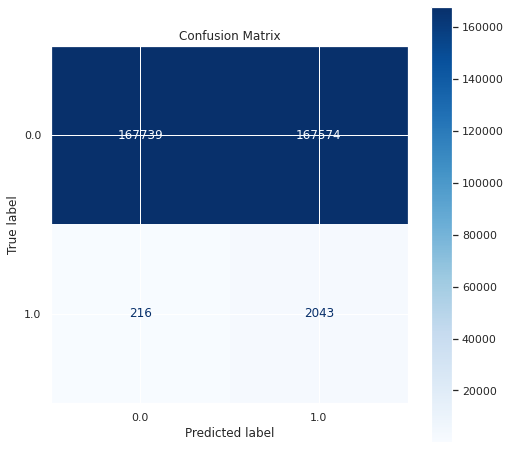

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9307')

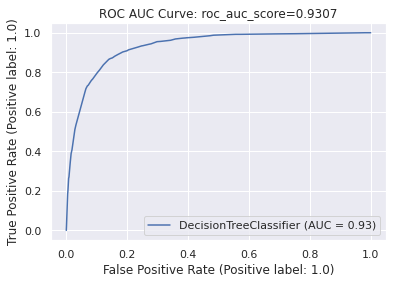

In [ ]:
disp = plot_roc_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1131')

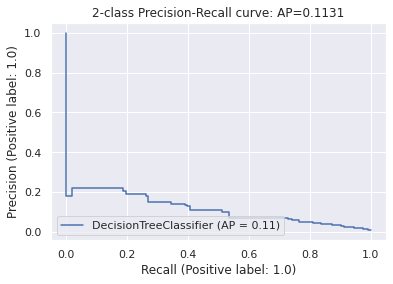

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.2.4. Random Forest

In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators': [100, 200], 'max_depth':[20,30,40,50,70,90,120,150]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 70, 'n_estimators': 200}
Best Score :  0.9607794545757065


In [ ]:
model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_power)
y_scores = model.predict_proba(X_test_iter_power)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9051
Recall Score:  0.9442
ROC AUC Score:  0.9705
Average Precision-Recall score:  0.2265


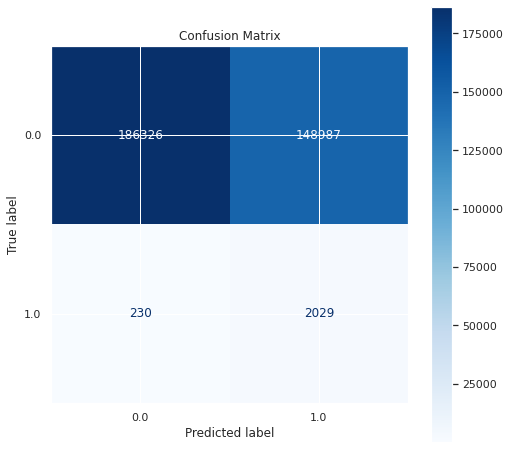

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9705')

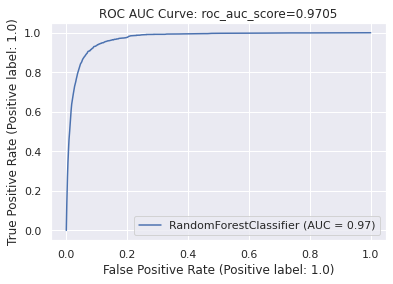

In [ ]:
disp = plot_roc_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2265')

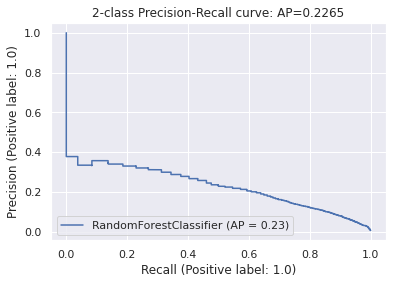

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.2.5. Xgboost

In [ ]:
model = XGBClassifier(n_jobs=-1, eval_metric='aucpr')
parameters = {'n_estimators': [100, 200,300], 'max_depth':[10,11,12,15,20,30,40,50]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 10, 'n_estimators': 200}
Best Score :  0.9560784151331531


In [ ]:
model = XGBClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1, eval_metric='aucpr')
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_power)
y_scores = model.predict_proba(X_test_iter_power)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9088
Recall Score:  0.9433
ROC AUC Score:  0.9683
Average Precision-Recall score:  0.2017


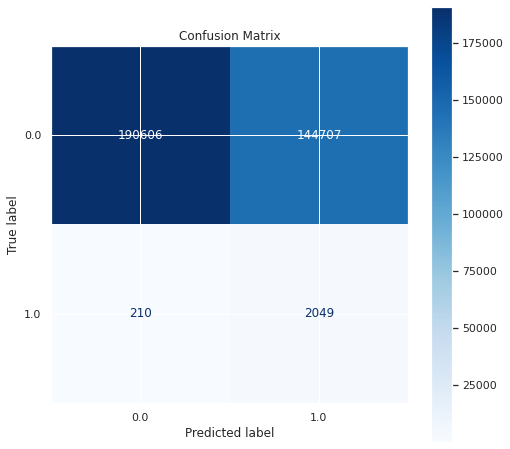

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9683')

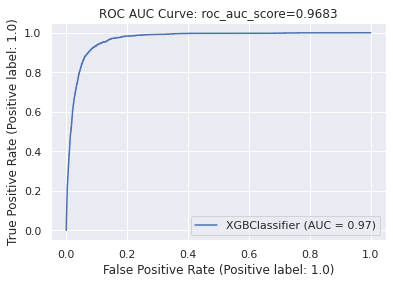

In [ ]:
disp = plot_roc_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2017')

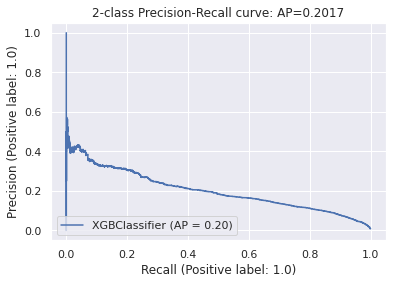

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_power, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.2.6. Custom Ensemble

In [ ]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']
scaler = PowerTransformer()
X_t, y_t, X_D1, y_D1, X_D2, y_D2 = data_split(X,y)
X_D1, X_D2, X_t = preprocessing_df(scaler, X_t, X_D1, X_D2)

#### 7.2.6.1. Random Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [27:07<00:00, 406.88s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 200


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9926
Recall Score:  0.0916
ROC AUC Score:  0.833
Average Precision-Recall score:  0.2578


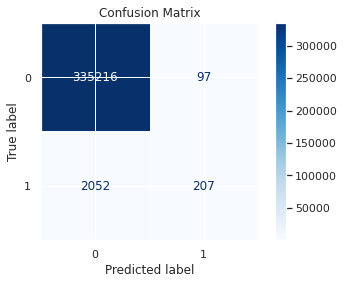

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

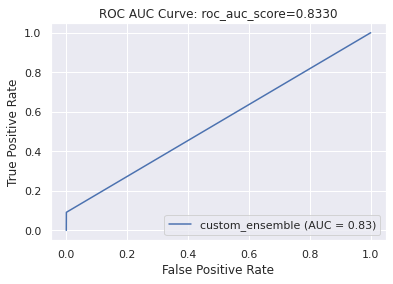

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

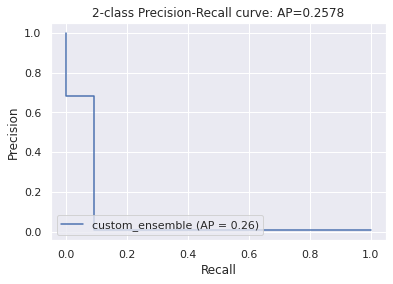

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

#### 7.2.6.2. Balanced Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [30:29<00:00, 457.32s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 200


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9921
Recall Score:  0.0549
ROC AUC Score:  0.9402
Average Precision-Recall score:  0.2641


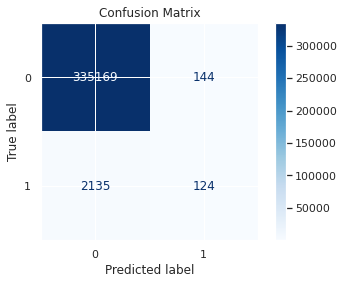

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

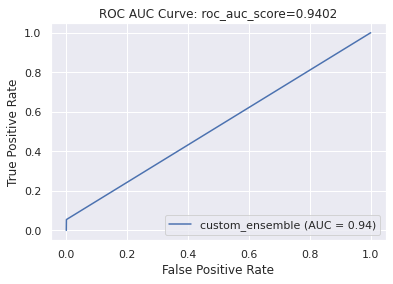

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

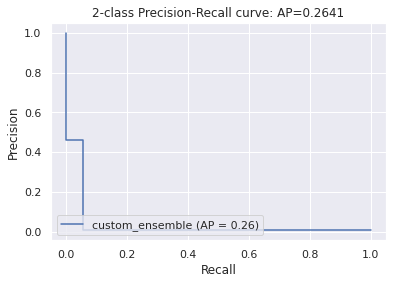

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

## 7.3. Log Transform

### 7.3.1. Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_iter_log, y_train)

In [ ]:
Xsampled = pd.DataFrame(X_res, columns=X_train_iter_log.columns)
Xsampled['went_on_backorder'] = y_res
Xsampled.to_csv('log_randomundersampling.csv', index=False)

In [ ]:
df = pd.read_csv('log_randomundersampling.csv')
X_res = df.drop(['went_on_backorder'], axis = 1)
y_res = df['went_on_backorder']

### 7.3.2. Logistic Regression

In [ ]:
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.1, 1.0, 10.0, 100.0, 1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'C': 1000.0, 'penalty': 'l2'}
Best Score :  0.9308343623507864


In [ ]:
model = LogisticRegression(penalty = gs.best_params_['penalty'],C = gs.best_params_['C'],n_jobs=-1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_log)
y_scores = model.predict_proba(X_test_iter_log)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8743
Recall Score:  0.8889
ROC AUC Score:  0.9387
Average Precision-Recall score:  0.1303


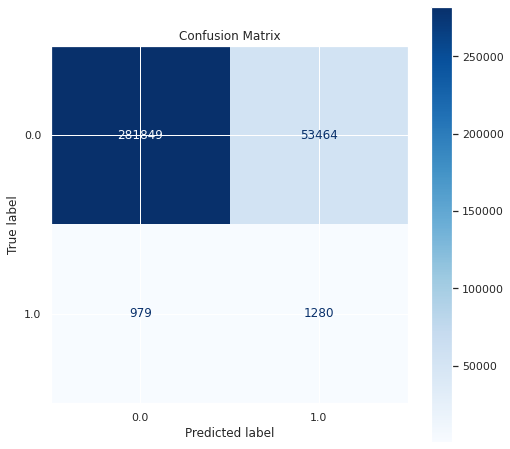

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9387')

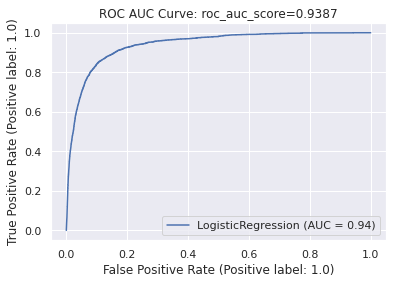

In [ ]:
disp = plot_roc_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1303')

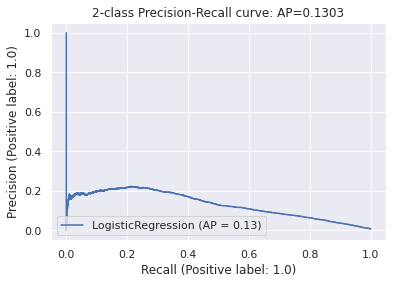

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.3.3. Decision Tree

In [ ]:
model = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'criterion': 'entropy', 'max_depth': 6}
Best Score :  0.9134422995146505


In [ ]:
model = DecisionTreeClassifier(criterion = gs.best_params_['criterion'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_log)
y_scores = model.predict_proba(X_test_iter_log)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8758
Recall Score:  0.8694
ROC AUC Score:  0.9307
Average Precision-Recall score:  0.1131


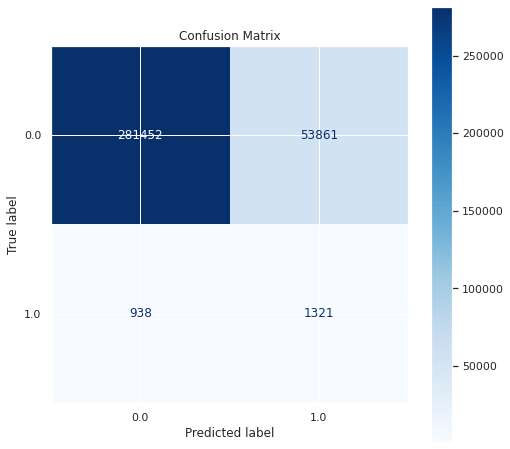

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9307')

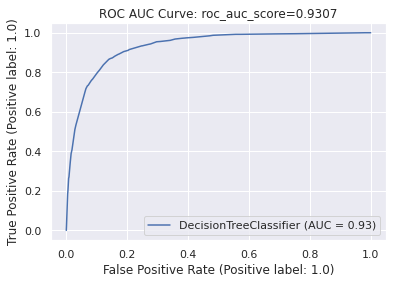

In [ ]:
disp = plot_roc_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1131')

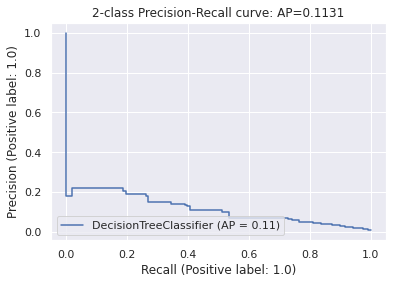

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.3.4. Random Forest

In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators': [100, 200], 'max_depth':[20,30,40,50,70,90,120,150]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 20, 'n_estimators': 200}
Best Score :  0.9605566031402164


In [ ]:
model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_log)
y_scores = model.predict_proba(X_test_iter_log)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9043
Recall Score:  0.942
ROC AUC Score:  0.9702
Average Precision-Recall score:  0.2599


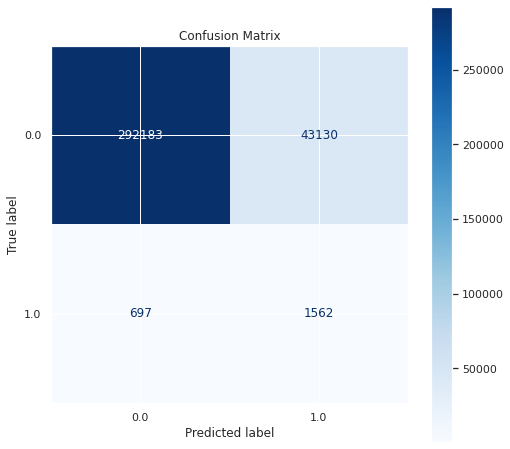

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9702')

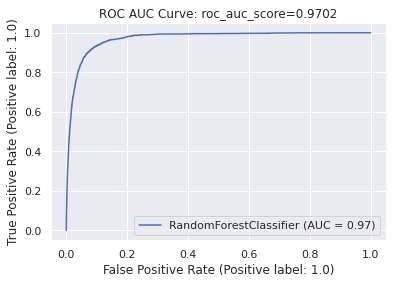

In [ ]:
disp = plot_roc_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2599')

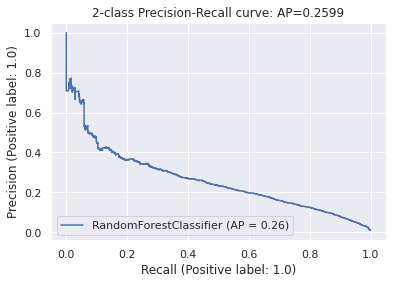

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.3.5. Xgboost

In [ ]:
model = XGBClassifier(n_jobs=-1, eval_metric='aucpr')
parameters = {'n_estimators': [100, 200,300], 'max_depth':[10,11,12,15,20,30,40,50]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 40, 'n_estimators': 100}
Best Score :  0.9563192537336406


In [ ]:
model = XGBClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1, eval_metric='aucpr')
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_log)
y_scores = model.predict_proba(X_test_iter_log)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9086
Recall Score:  0.942
ROC AUC Score:  0.9682
Average Precision-Recall score:  0.2014


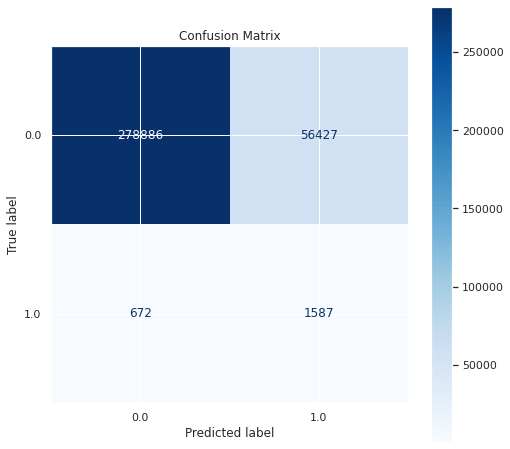

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9682')

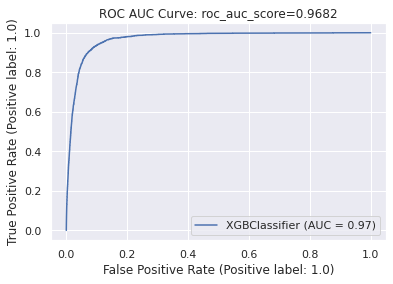

In [ ]:
disp = plot_roc_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2014')

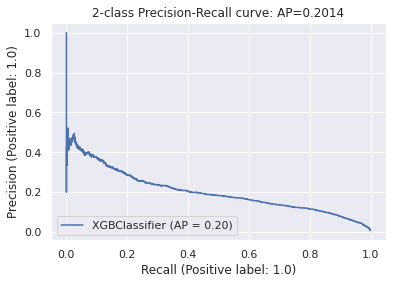

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_log, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.3.6. Custom Ensemble

In [ ]:
log_columns = []
for i in skewed:
  log_columns.append(X.columns.get_loc(i))

In [ ]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']
scaler = StandardScaler()
X_t, y_t, X_D1, y_D1, X_D2, y_D2 = data_split(X,y)
log_columns = []
for i in skewed:
  log_columns.append(X.columns.get_loc(i))
X_t[:] = np.apply_along_axis(log_transform, 1, X_t)
X_D1[:] = np.apply_along_axis(log_transform, 1, X_D1)
X_D2[:] = np.apply_along_axis(log_transform, 1, X_D2)

X_D1, X_D2, X_t = preprocessing_df(scaler, X_t, X_D1, X_D2)

#### 7.3.6.1. Random Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [27:13<00:00, 408.30s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 200


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9925
Recall Score:  0.0841
ROC AUC Score:  0.8444
Average Precision-Recall score:  0.266


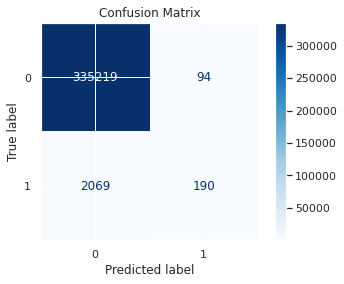

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

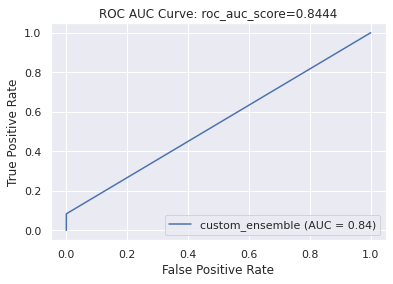

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

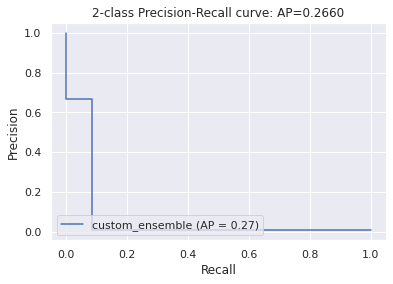

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

#### 7.3.6.2. Balanced Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [31:25<00:00, 471.33s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 300


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9921
Recall Score:  0.0469
ROC AUC Score:  0.9433
Average Precision-Recall score:  0.2685


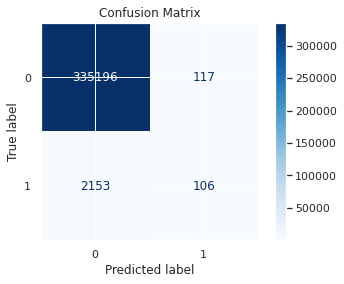

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

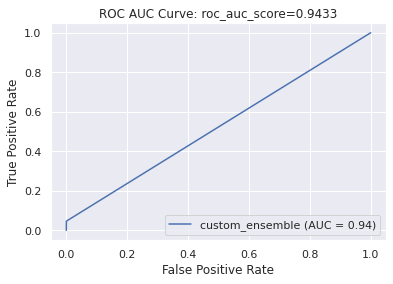

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

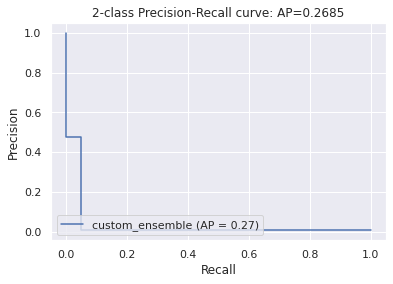

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

## 7.4. MaxAbs Scaling

### 7.4.1. Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_iter_maxabs, y_train)

In [ ]:
Xsampled = pd.DataFrame(X_res, columns=X_train_iter_maxabs.columns)
Xsampled['went_on_backorder'] = y_res
Xsampled.to_csv('maxabs_randomundersampling.csv', index=False)

In [ ]:
df = pd.read_csv('maxabs_randomundersampling.csv')
X_res = df.drop(['went_on_backorder'], axis = 1)
y_res = df['went_on_backorder']

### 7.4.2. Logistic Regression

In [ ]:
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.1, 1.0, 10.0, 100.0, 1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'C': 1000.0, 'penalty': 'l2'}
Best Score :  0.6334210398137068


In [ ]:
model = LogisticRegression(penalty = gs.best_params_['penalty'],C = gs.best_params_['C'],n_jobs=-1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_maxabs)
y_scores = model.predict_proba(X_test_iter_maxabs)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.678
Recall Score:  0.5573
ROC AUC Score:  0.6404
Average Precision-Recall score:  0.0132


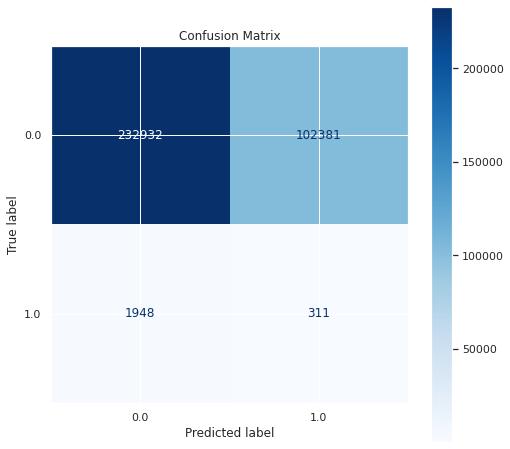

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.6404')

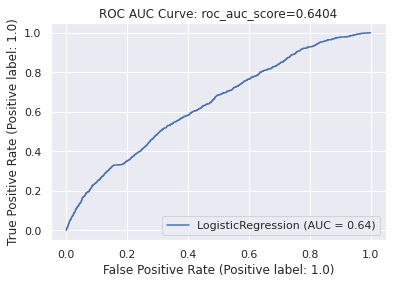

In [ ]:
disp = plot_roc_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0132')

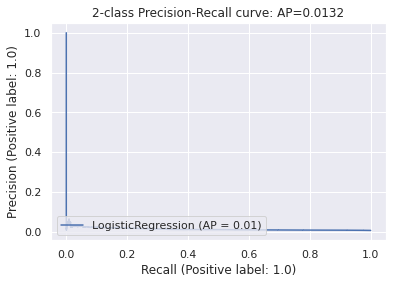

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.4.3. Decision Tree

In [ ]:
model = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'criterion': 'entropy', 'max_depth': 7}
Best Score :  0.8608815202662775


In [ ]:
model = DecisionTreeClassifier(criterion = gs.best_params_['criterion'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_maxabs)
y_scores = model.predict_proba(X_test_iter_maxabs)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8178
Recall Score:  0.8867
ROC AUC Score:  0.8972
Average Precision-Recall score:  0.0479


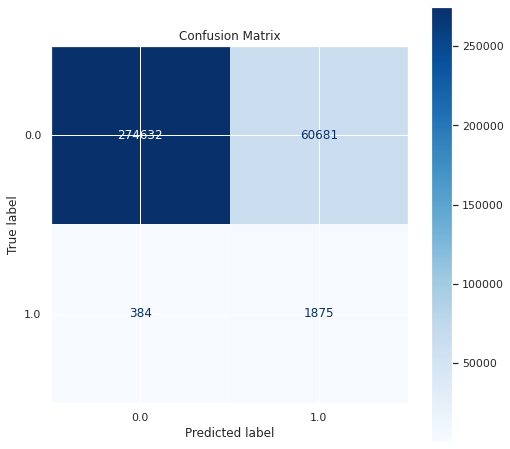

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.8972')

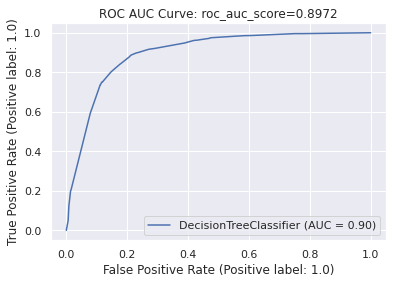

In [ ]:
disp = plot_roc_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0479')

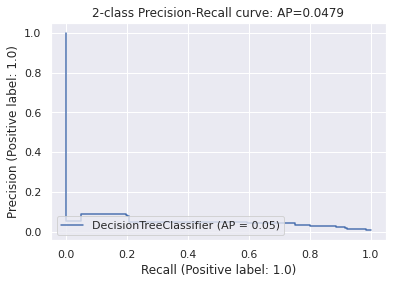

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.4.4. Random Forest

In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators': [100, 200], 'max_depth':[20,30,40,50,70,90,120,150]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 150, 'n_estimators': 200}
Best Score :  0.9542374322623933


In [ ]:
model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_maxabs)
y_scores = model.predict_proba(X_test_iter_maxabs)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8918
Recall Score:  0.9411
ROC AUC Score:  0.9653
Average Precision-Recall score:  0.2222


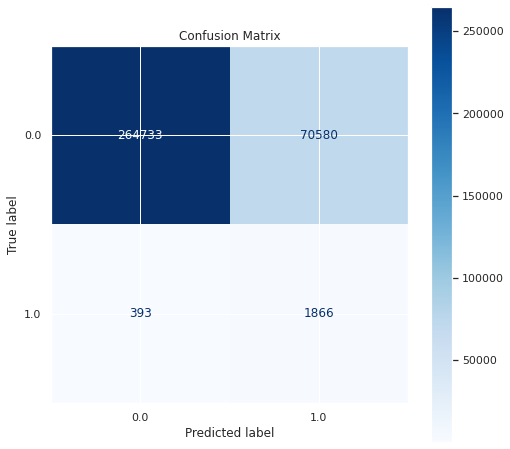

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9653')

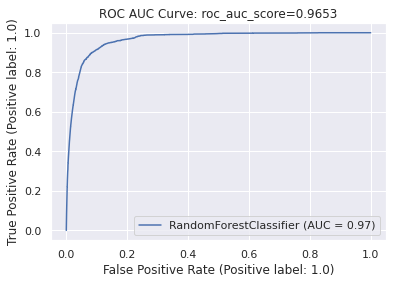

In [ ]:
disp = plot_roc_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2222')

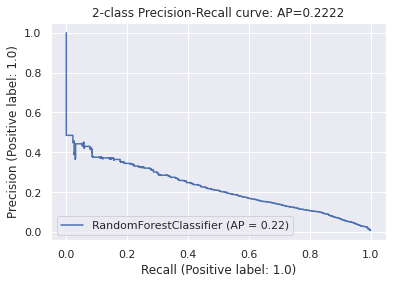

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.4.5. Xgboost

In [ ]:
model = XGBClassifier(n_jobs=-1, eval_metric='aucpr')
parameters = {'n_estimators': [100, 200,300], 'max_depth':[10,11,12,15,20,30,40,50]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 30, 'n_estimators': 100}
Best Score :  0.9568057328089117


In [ ]:
model = XGBClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1, eval_metric='aucpr')
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_maxabs)
y_scores = model.predict_proba(X_test_iter_maxabs)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9094
Recall Score:  0.9442
ROC AUC Score:  0.9684
Average Precision-Recall score:  0.2


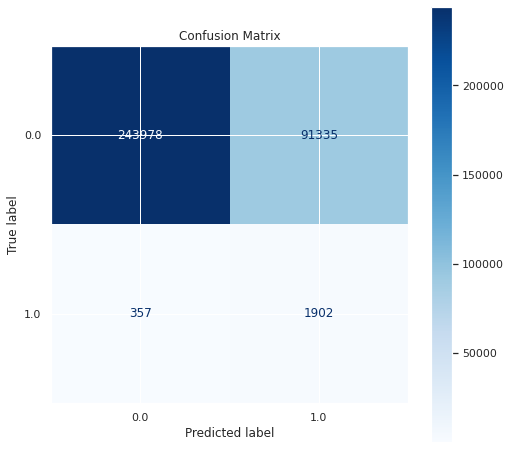

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9684')

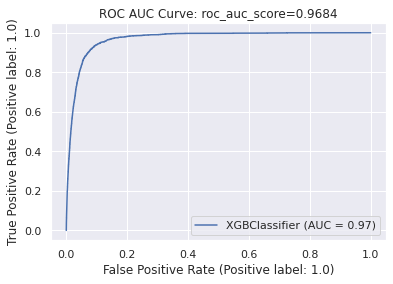

In [ ]:
disp = plot_roc_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2000')

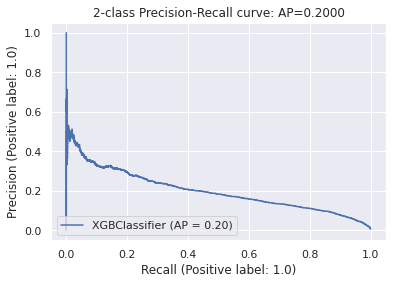

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_maxabs, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.4.6. Custom Ensemble

In [ ]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']
scaler = MaxAbsScaler()
X_t, y_t, X_D1, y_D1, X_D2, y_D2 = data_split(X,y)
X_D1, X_D2, X_t = preprocessing_df(scaler, X_t, X_D1, X_D2)

#### 7.4.6.1. Random Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [27:51<00:00, 417.87s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 100


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9924
Recall Score:  0.077
ROC AUC Score:  0.8113
Average Precision-Recall score:  0.2019


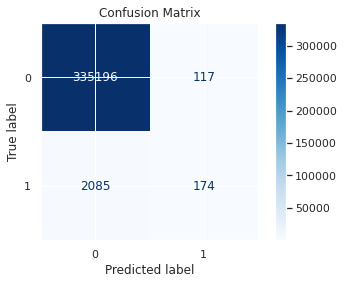

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

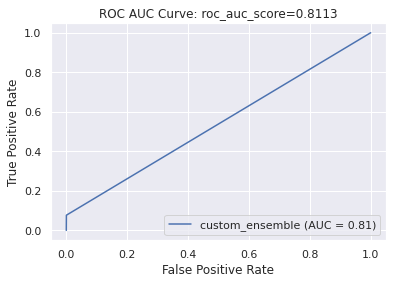

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

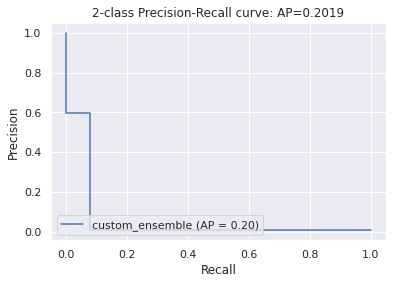

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

#### 7.4.6.2. Balanced Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [31:48<00:00, 477.21s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 300


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9922
Recall Score:  0.066
ROC AUC Score:  0.9424
Average Precision-Recall score:  0.25


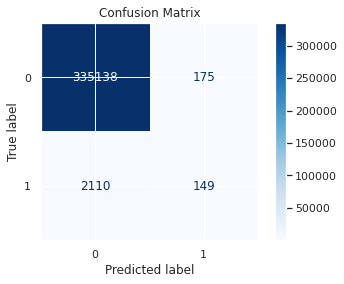

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

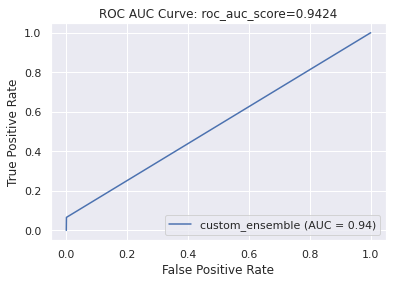

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

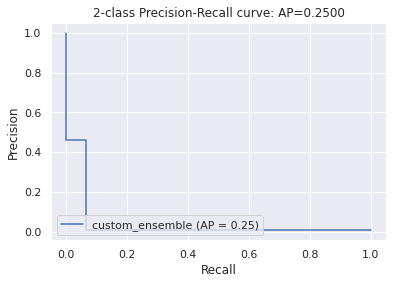

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

## 7.5. Quantile Transform

### 7.5.1. Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_iter_quantile, y_train)

In [ ]:
Xsampled = pd.DataFrame(X_res, columns=X_train_iter_quantile.columns)
Xsampled['went_on_backorder'] = y_res
Xsampled.to_csv('quantile_randomundersampling.csv', index=False)

In [ ]:
df = pd.read_csv('quantile_randomundersampling.csv')
X_res = df.drop(['went_on_backorder'], axis = 1)
y_res = df['went_on_backorder']

### 7.5.2. Logistic Regression

In [ ]:
model = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' : [0.1, 1.0, 10.0, 100.0, 1000.0]}
clf = GridSearchCV(model, parameters,scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'C': 100.0, 'penalty': 'l2'}
Best Score :  0.9231529921467289


In [ ]:
model = LogisticRegression(penalty = gs.best_params_['penalty'],C = gs.best_params_['C'],n_jobs=-1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_quantile)
y_scores = model.predict_proba(X_test_iter_quantile)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8735
Recall Score:  0.865
ROC AUC Score:  0.9305
Average Precision-Recall score:  0.121


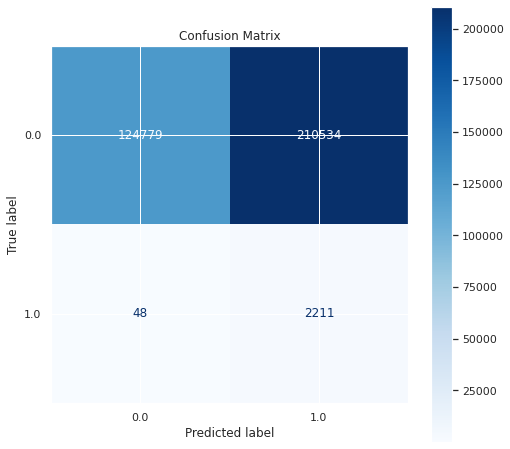

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9305')

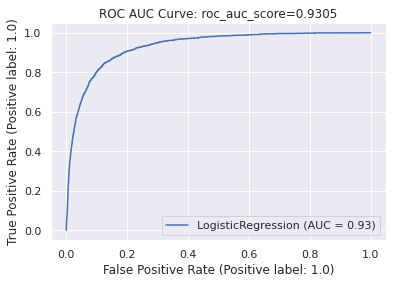

In [ ]:
disp = plot_roc_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1210')

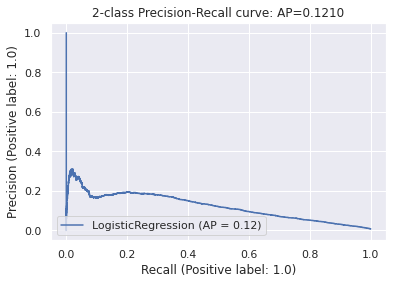

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.5.3. Decision Tree

In [ ]:
model = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'criterion': 'entropy', 'max_depth': 6}
Best Score :  0.9134165389979497


In [ ]:
model = DecisionTreeClassifier(criterion = gs.best_params_['criterion'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_quantile)
y_scores = model.predict_proba(X_test_iter_quantile)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.8758
Recall Score:  0.8694
ROC AUC Score:  0.9307
Average Precision-Recall score:  0.1132


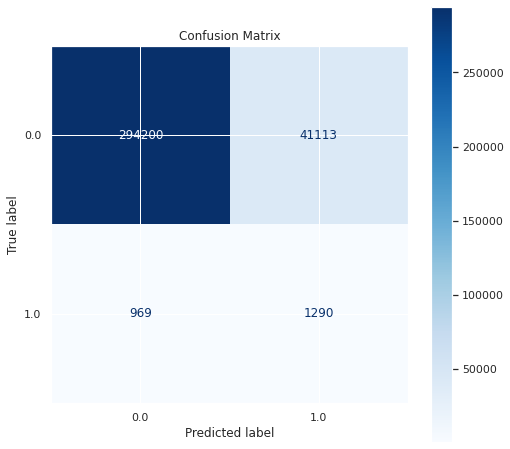

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9307')

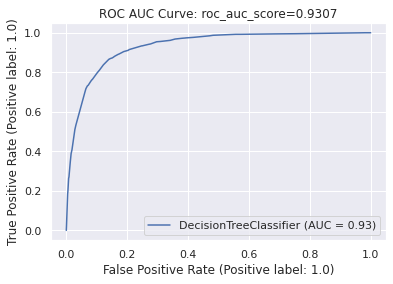

In [ ]:
disp = plot_roc_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1132')

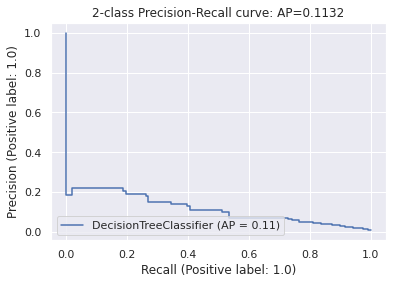

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.5.4. Random Forest

In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators': [100, 200], 'max_depth':[20,30,40,50,70,90,120,150]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 20, 'n_estimators': 100}
Best Score :  0.9605492070671368


In [ ]:
model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_quantile)
y_scores = model.predict_proba(X_test_iter_quantile)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9044
Recall Score:  0.942
ROC AUC Score:  0.9696
Average Precision-Recall score:  0.24


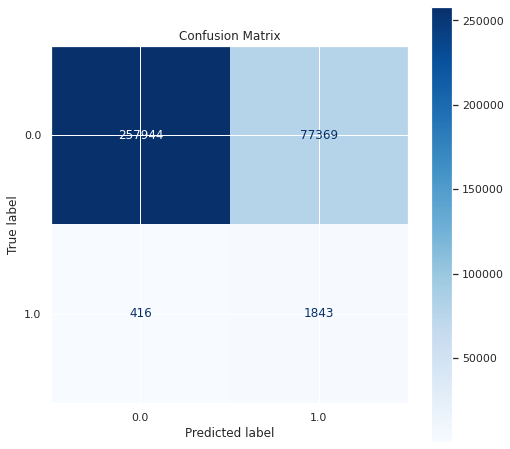

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9696')

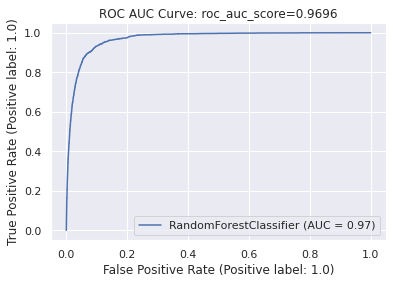

In [ ]:
disp = plot_roc_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2400')

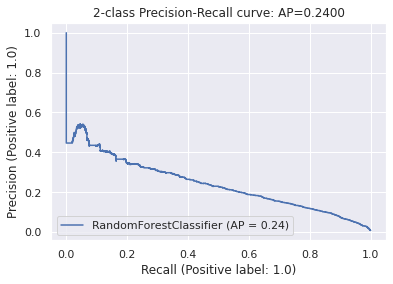

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.5.5. Xgboost

In [ ]:
model = XGBClassifier(n_jobs=-1, eval_metric='aucpr')
parameters = {'n_estimators': [100, 200,300], 'max_depth':[10,11,12,15,20,30,40,50]}

clf = GridSearchCV(model, parameters, scoring = 'average_precision')

gs = clf.fit(X_res, y_res)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 11, 'n_estimators': 200}
Best Score :  0.9564511047178248


In [ ]:
model = XGBClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1, eval_metric='aucpr')
model.fit(X_res, y_res)
y_pred = model.predict(X_test_iter_quantile)
y_scores = model.predict_proba(X_test_iter_quantile)[:,1]

print("F2-Score: ", round(fbeta_score(y_test,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_test, y_pred),4))

roc_auc = roc_auc_score(y_test, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_test, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9088
Recall Score:  0.9429
ROC AUC Score:  0.9677
Average Precision-Recall score:  0.1942


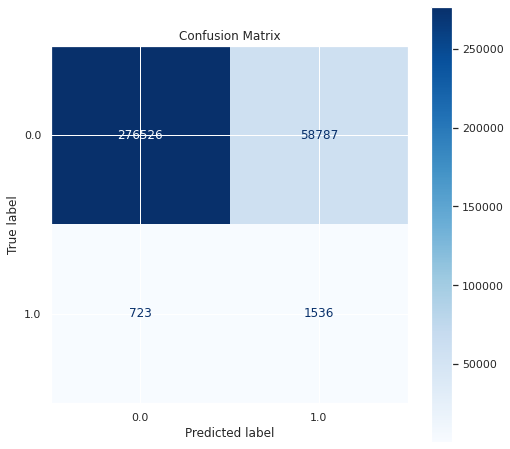

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
disp = plot_confusion_matrix(model, X_test_iter_robust, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9677')

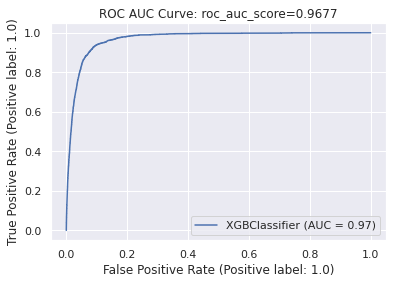

In [ ]:
disp = plot_roc_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1942')

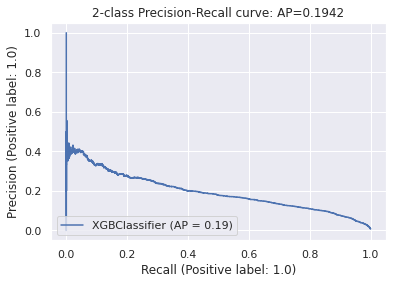

In [ ]:
disp = plot_precision_recall_curve(model, X_test_iter_quantile, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

### 7.5.6. Custom Ensemble Model

In [ ]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']
scaler = QuantileTransformer()
X_t, y_t, X_D1, y_D1, X_D2, y_D2 = data_split(X,y)
X_D1, X_D2, X_t = preprocessing_df(scaler, X_t, X_D1, X_D2)

#### 7.5.6.1. Random Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [26:51<00:00, 402.77s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 200


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_random(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9926
Recall Score:  0.0943
ROC AUC Score:  0.8345
Average Precision-Recall score:  0.2477


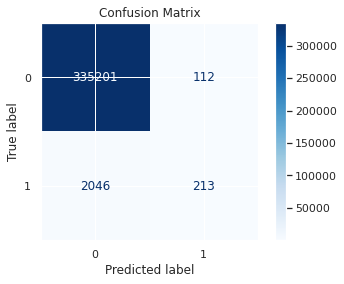

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

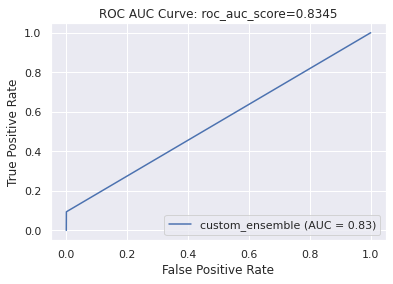

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

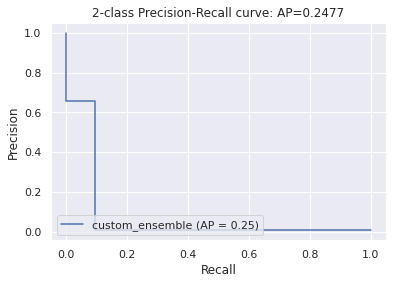

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

#### 7.5.6.1. Balanced Sampling

In [ ]:
params = []
scores = []
n_estimators = [100, 200, 300]
num_splits = [20,30,40,50]
for split in tqdm(num_splits):
    for num in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=120)
        meta_model = RandomForestClassifier(n_estimators=num)
        score,_,_ = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, split)
        scores.append(score)
        params.append((split, num))

100%|██████████| 4/4 [31:01<00:00, 465.48s/it]


In [ ]:
best_score_idx = np.argmax(scores)
best_params = params[best_score_idx]
best_split = best_params[0]
best_num = best_params[1]
print("Best parameters are: num_splits - {}, n_estimators - {}".format(best_split,best_num))

Best parameters are: num_splits - 50, n_estimators - 100


In [ ]:
base_model = DecisionTreeClassifier(max_depth=120)
meta_model = RandomForestClassifier(n_estimators=best_num)
score,y_pred,y_scores = custom_ensemble_balanced(base_model, meta_model, X_D1, X_D2, X_t, y_D1, y_D2, y_t, scaler, best_split)

print("F2-Score: ", round(fbeta_score(y_t,y_pred, pos_label = 1,average='weighted', beta=2),4))
print("Recall Score: ", round(recall_score(y_t, y_pred),4))

roc_auc = roc_auc_score(y_t, y_scores, average='weighted')
print("ROC AUC Score: ", round(roc_auc,4))

average_precision = average_precision_score(y_t, y_scores)
print('Average Precision-Recall score: ', round(average_precision,4))

F2-Score:  0.9921
Recall Score:  0.0465
ROC AUC Score:  0.9276
Average Precision-Recall score:  0.2562


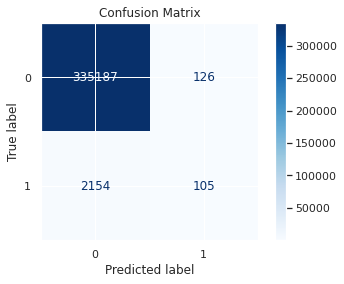

In [ ]:
cm = confusion_matrix(y_t, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
ax.set_title('Confusion Matrix')
disp.plot(cmap=plt.cm.Blues, ax=ax)

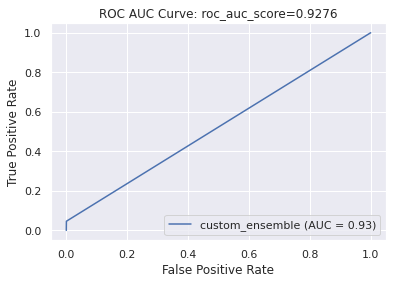

In [ ]:
fpr, tpr, _ = roc_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='custom_ensemble')
ax.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc_auc))
disp.plot(ax)

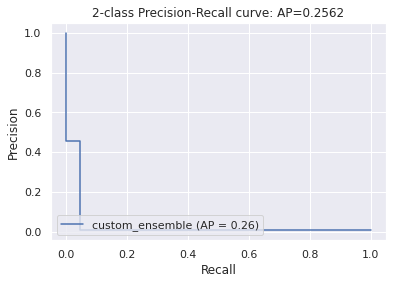

In [ ]:
precision, recall, _ = precision_recall_curve(y_t, y_pred)
fig, ax = plt.subplots()
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision= average_precision, estimator_name='custom_ensemble')
ax.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))
disp.plot(ax)

# 8. Conclusion

## 8.1. Comparison of models on the basis of their 'Average Precision Score'

In [ ]:
from prettytable import PrettyTable

In [ ]:
myTable = PrettyTable(["Feature Transform", "Logistic Regression", "Decision Tree", "Random Forest", "Xgboost", "Custom Ensemble(Random Sampling)", "Custom Ensemble(Balanced Sampling)"])

In [ ]:
myTable.add_row(["Robust Scaling", "0.0261", "0.1132", "0.2583", "0.2083", "0.2450", "0.2517"])
myTable.add_row(["Powerlaw Transform", "0.0732", "0.1131", "0.2265", "0.2017", "0.2578", "0.2641"])
myTable.add_row(["Log Transform", "0.1303", "0.1131", "0.2599", "0.2014", "0.2660", "0.2685"])
myTable.add_row(["MaxAbs Scaling", "0.0132", "0.0479", "0.2222", "0.2000", "0.2019", "0.2500"])
myTable.add_row(["Quantile Transform", "0.1210", "0.1132", "0.2400", "0.1942", "0.2477", "0.2562"])
print(myTable)

+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
| Feature Transform  | Logistic Regression | Decision Tree | Random Forest | Xgboost | Custom Ensemble(Random Sampling) | Custom Ensemble(Balanced Sampling) |
+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
|   Robust Scaling   |        0.0261       |     0.1132    |     0.2583    |  0.2083 |              0.2450              |               0.2517               |
| Powerlaw Transform |        0.0732       |     0.1131    |     0.2265    |  0.2017 |              0.2578              |               0.2641               |
|   Log Transform    |        0.1303       |     0.1131    |     0.2599    |  0.2014 |              0.2660              |               0.2685               |
|   MaxAbs Scaling   |        0.0132       |  

## 8.2. Comparison of models on the basis of their 'ROC AUC Score'

In [ ]:
myTable = PrettyTable(["Feature Transform", "Logistic Regression", "Decision Tree", "Random Forest", "Xgboost", "Custom Ensemble(Random Sampling)", "Custom Ensemble(Balanced Sampling)"])

In [ ]:
myTable.add_row(["Robust Scaling", "0.7701", "0.9306", "0.9702", "0.9685", "0.8352", "0.9347"])
myTable.add_row(["Powerlaw Transform", "0.8986", "0.9307", "0.9705", "0.9683", "0.8330", "0.9402"])
myTable.add_row(["Log Transform", "0.9387", "0.9307", "0.9702", "0.9682", "0.8444", "0.9433"])
myTable.add_row(["MaxAbs Scaling", "0.6404", "0.8972", "0.9653", "0.9684", "0.8113", "0.9424"])
myTable.add_row(["Quantile Transform", "0.9305", "0.9307", "0.9696", "0.9677", "0.8345", "0.9276"])
print(myTable)

+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
| Feature Transform  | Logistic Regression | Decision Tree | Random Forest | Xgboost | Custom Ensemble(Random Sampling) | Custom Ensemble(Balanced Sampling) |
+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
|   Robust Scaling   |        0.7701       |     0.9306    |     0.9702    |  0.9685 |              0.8352              |               0.9347               |
| Powerlaw Transform |        0.8986       |     0.9307    |     0.9705    |  0.9683 |              0.8330              |               0.9402               |
|   Log Transform    |        0.9387       |     0.9307    |     0.9702    |  0.9682 |              0.8444              |               0.9433               |
|   MaxAbs Scaling   |        0.6404       |  

## 8.3. Comparison of models on the basis of their 'Recall Score'

In [ ]:
myTable = PrettyTable(["Feature Transform", "Logistic Regression", "Decision Tree", "Random Forest", "Xgboost", "Custom Ensemble(Random Sampling)", "Custom Ensemble(Balanced Sampling)"])

In [ ]:
myTable.add_row(["Robust Scaling", "0.6698", "0.8690", "0.9433", "0.9425", "0.0899", "0.0469"])
myTable.add_row(["Powerlaw Transform", "0.8336", "0.8694", "0.9442", "0.9433", "0.0916", "0.0549"])
myTable.add_row(["Log Transform", "0.8889", "0.8694", "0.9420", "0.9420", "0.0841", "0.0469"])
myTable.add_row(["MaxAbs Scaling", "0.5573", "0.8867", "0.9411", "0.9442", "0.0770", "0.0660"])
myTable.add_row(["Quantile Transform", "0.8650", "0.8694", "0.9420", "0.9429", "0.0943", "0.0465"])
print(myTable)

+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
| Feature Transform  | Logistic Regression | Decision Tree | Random Forest | Xgboost | Custom Ensemble(Random Sampling) | Custom Ensemble(Balanced Sampling) |
+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
|   Robust Scaling   |        0.6698       |     0.8690    |     0.9433    |  0.9425 |              0.0899              |               0.0469               |
| Powerlaw Transform |        0.8336       |     0.8694    |     0.9442    |  0.9433 |              0.0916              |               0.0549               |
|   Log Transform    |        0.8889       |     0.8694    |     0.9420    |  0.9420 |              0.0841              |               0.0469               |
|   MaxAbs Scaling   |        0.5573       |  

## 8.4. Comparison of models on the basis of their 'F2 Score'

In [ ]:
myTable = PrettyTable(["Feature Transform", "Logistic Regression", "Decision Tree", "Random Forest", "Xgboost", "Custom Ensemble(Random Sampling)", "Custom Ensemble(Balanced Sampling)"])

In [ ]:
myTable.add_row(["Robust Scaling", "0.7409", "0.8759", "0.9041", "0.9090", "0.9925", "0.9920"])
myTable.add_row(["Powerlaw Transform", "0.8536", "0.8758", "0.9051", "0.9088", "0.9926", "0.9921"])
myTable.add_row(["Log Transform", "0.8743", "0.8758", "0.9043", "0.9086", "0.9925", "0.9921"])
myTable.add_row(["MaxAbs Scaling", "0.6780", "0.8178", "0.8918", "0.9094", "0.9924", "0.9922"])
myTable.add_row(["Quantile Transform", "0.8735", "0.8758", "0.9044", "0.9068", "0.9926", "0.9921"])
print(myTable)

+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
| Feature Transform  | Logistic Regression | Decision Tree | Random Forest | Xgboost | Custom Ensemble(Random Sampling) | Custom Ensemble(Balanced Sampling) |
+--------------------+---------------------+---------------+---------------+---------+----------------------------------+------------------------------------+
|   Robust Scaling   |        0.7409       |     0.8759    |     0.9041    |  0.9090 |              0.9925              |               0.9920               |
| Powerlaw Transform |        0.8536       |     0.8758    |     0.9051    |  0.9088 |              0.9926              |               0.9921               |
|   Log Transform    |        0.8743       |     0.8758    |     0.9043    |  0.9086 |              0.9925              |               0.9921               |
|   MaxAbs Scaling   |        0.6780       |  

## 8.5. Observations

- Logistic Regression performs best with Log Transform with Avergae-Precision Score = 0.1303, ROC AUC Score = 0.9387, Recall Score = 0.8889 adn F2 Score = 0.8743.
- Decision Tree performed worst with MaxAbsScaling and with other four it performance was similar.
- Random Forest performed best with Powerlaw Transform with Avergae-Precision Score = 0.2265, ROC AUC Score = 0.9705, Recall Score = 0.9442 adn F2 Score = 0.9051.
- Xgboost performed was comparable with Robust Scaling and MaxAbsScaling.
- Custom Ensemble with Random Sampling performed best with Log Transform.
- Custom Ensemble with Balanced Sampling performed best with Log Transform.
- If we consider F2 score alone the Custom Ensemble models seem to be performing best but this incorrect if we consider Recall score also.
- By seeing Recall score it becomes clear that the Custom Ensemble models are performing worst and seems unfit for predictions.
- The reason for Custom Ensemble models having high F2 scores and Average Precision-Recall score could be because they were predicting majority classes more.
- Overall the best performing model is Random Forest Classifier with PowerLaw Transformer.